<a href="https://colab.research.google.com/github/berinaysrl/DSA210--Term-Project/blob/main/DSA210_TERM_PROJECT_REPORT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSA210 TERM PROJECT**

*Note: Please check out my slides for a better follow up, from GitHub.*

In this project, I am exploring my studying habits and my social media usage by first exploring them individually, and then combining them in order to come up with an outcome.

My aim is to find a correlation between these two habits of mine, and my (null) hypotheses are:

 1. Hourly Correlation: There is no monotonic relationship between hourly study hours and Instagram usage.

 2. Daily Correlation: There is no monotonic relationship between daily study hours and Instagram usage.


*The social media platform is chosen as Instagram, since it is mostly what I use for procrastination.*  

Below, I will introduce my methods and code snippets as I explore whether I will reject or fail to reject the null hypotheses at the very end.  


**Importing Necessary Libraries**


In [ ]:
import pandas as pd
import json
from datetime import datetime, timezone, timedelta
from collections import Counter
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, chi2_contingency
import warnings
from tabulate import tabulate



# **PREPROCESSING AND ANONYMIZING DATA**
Below, I will anonymize my data, by only keeping the necessary information and excluding sensitive elements from the raw data.

**1) Preprocessing "Forest App" Data**

In [ ]:
import pandas as pd
import os

if not os.path.exists('processed_data_forest'):
    os.makedirs('processed_data_forest')


file_path = '/content/Plants_of_berinayzumrasariel.csv'
df_forest = pd.read_csv(file_path)


df_forest['Start Time'] = pd.to_datetime(df_forest['Start Time'])
df_forest['date'] = df_forest['Start Time'].dt.date

daily_study = df_forest.groupby('date').size().reset_index(name='total_study_sessions')
daily_study.to_csv('processed_data_forest/daily_study.csv', index=False)
print("Daily study times have been processed and saved.")

daily_tag_summary = df_forest.groupby(['date', 'Tag']).size().reset_index(name='study_sessions')
daily_tag_summary.to_csv('processed_data_forest/daily_tag_summary.csv', index=False)
print("Daily tag-wise study times have been processed and saved.")
daily_study
daily_tag_summary

Daily study times have been processed and saved.
Daily tag-wise study times have been processed and saved.


date               Tag  study_sessions
0    2022-09-16   writing stories               1
1    2022-09-18   writing stories               2
2    2022-09-21             Unset               1
3    2022-10-02  studying italian               1
4    2022-10-03  studying italian               1
..          ...               ...             ...
319  2024-11-14             CS204               4
320  2024-11-15             CS204               6
321  2024-11-16             CS204               1
322  2024-11-18            HUM201               3
323  2024-11-19            HUM201               1

[324 rows x 3 columns]

Meanwhile as I worked on this project, I noticed that I have either misrecorded some courses that I worked on, tagging them as "Unset" or "Study". Also, I have noticed that I tend not to record while I am doing groupwork like we had in PROJ201, or while I was a part-time worker in CDP (which is the "CDP" tag that I once created) is not so used consistently. So I considered it as garbage data, and decided to exlcude their tags.

For the "Unset" and "Study" tags, I decided to randomly distribute the time I have recorded according to their weights, which become their probabilities.

By their probabilities I mean that if CS204 is the one course I am mostly working on the current academic term, it is more likely that I have studied for it under the tag "Unset", and if I study less for NS206, it is less likely that I studied for it under the name tag "Unset" or "Study".

Below, you may see the randomization and data clearing process.

In [ ]:

file_path = '/content/Plants_of_berinayzumrasariel.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The specified file does not exist: {file_path}")

data = pd.read_csv(file_path)

columns_to_drop = ['Note', 'Tree Type', 'Is Success']
data = data.drop(columns=columns_to_drop, errors='ignore')

data['Start Time'] = pd.to_datetime(data['Start Time'], errors='coerce')
data['End Time'] = pd.to_datetime(data['End Time'], errors='coerce')

data = data.dropna(subset=['Start Time', 'End Time'])

data['Duration (hours)'] = (data['End Time'] - data['Start Time']).dt.total_seconds() / 3600

data['Tag'] = data['Tag'].replace({
    'CS204 1': 'CS204',
    'SPS': 'SPS102',
    'SPS102 1': 'SPS102' })

data = data[~data['Tag'].isin(['CDP', 'PROJ201'])]

unset_data = data[data['Tag'] == 'Unset']
study_data = data[data['Tag'] == 'Study']
filtered_data = data[~data['Tag'].isin(['Unset', 'Study'])].copy()


if not filtered_data.empty:
    total_hours = filtered_data['Duration (hours)'].sum()
    filtered_data['Weight'] = filtered_data['Duration (hours)'] / total_hours
else:
    filtered_data['Weight'] = 0

total_unset_hours = unset_data['Duration (hours)'].sum()
total_study_hours = study_data['Duration (hours)'].sum()
total_unset_sessions = len(unset_data)
total_study_sessions = len(study_data)

filtered_data['Distributed Unset Hours'] = filtered_data['Weight'] * total_unset_hours
filtered_data['Distributed Study Hours'] = filtered_data['Weight'] * total_study_hours
filtered_data['Distributed Unset Sessions'] = filtered_data['Weight'] * total_unset_sessions
filtered_data['Distributed Study Sessions'] = filtered_data['Weight'] * total_study_sessions


filtered_data['Adjusted Hours'] = (
    filtered_data['Duration (hours)'] +
    filtered_data['Distributed Unset Hours'] +
    filtered_data['Distributed Study Hours']
)
filtered_data['Adjusted Sessions'] = (
    filtered_data['Distributed Unset Sessions'] +
    filtered_data['Distributed Study Sessions']
)

filtered_data.fillna(0, inplace=True)

output_path = '/content/Cleaned_and_Adjusted_Study_Data.csv'
filtered_data.to_csv(output_path, index=False)

print("Cleaned and Adjusted Study Data:")
print(filtered_data)
print(f"Data cleaned and saved to {output_path}")

Cleaned and Adjusted Study Data:
                          Start Time                         End Time  \
0   2022-09-16 14:20:58.882000+03:00 2022-09-16 15:20:58.882000+03:00   
1   2022-09-18 12:59:44.214000+03:00 2022-09-18 13:59:44.214000+03:00   
2   2022-09-18 14:17:27.075000+03:00 2022-09-18 15:17:27.075000+03:00   
4   2022-10-02 14:13:15.245000+03:00 2022-10-02 15:43:15.245000+03:00   
5   2022-10-03 13:59:11.853000+03:00 2022-10-03 14:19:11.853000+03:00   
..                               ...                              ...   
598 2024-11-16 09:55:33.803000+03:00 2024-11-16 11:55:33.803000+03:00   
599 2024-11-18 12:25:25.777000+03:00 2024-11-18 13:32:13.102000+03:00   
600 2024-11-18 13:48:28.659000+03:00 2024-11-18 15:00:11.110000+03:00   
601 2024-11-18 18:58:38.436000+03:00 2024-11-18 20:58:38.436000+03:00   
602 2024-11-19 10:47:00.315000+03:00 2024-11-19 12:13:29.308000+03:00   

                  Tag  Duration (hours)    Weight  Distributed Unset Hours  \
0     writin

**2)Preprocessing Instagram "Likes" Data**

Below, you may see the preprocessing procedure of the raw Instagram data that I have requested from Meta. With this way, I have excluded some considerably sensitive information such as the links of the reels/posts that I have liked, and the username of their owners, and kept the rest of the information, which is time and date.

The first block of code extracts the time and date information, and the hour on the second column, which will be used later for some graphs that we will obtain.

Second block of the code only extracts the timestamp information.


In [ ]:

raw_file_path = '/content/liked_posts.json'
with open(raw_file_path, 'r') as file:
    data = json.load(file)

timestamps = []
for like in data['likes_media_likes']:
    for item in like['string_list_data']:

        utc_timestamp = int(item['timestamp'])
        dt_utc = datetime.fromtimestamp(utc_timestamp, tz=timezone.utc)
        timestamps.append(dt_utc)

likes_df = pd.DataFrame({'timestamp': timestamps})
likes_df['timestamp'] = likes_df['timestamp'].dt.tz_convert('Europe/Istanbul')
likes_df['hour'] = likes_df['timestamp'].dt.hour

processed_file_path = '/content/processed_likes.csv'
likes_df.to_csv(processed_file_path, index=False)
print(f"Preprocessed data saved to {processed_file_path}")


Preprocessed data saved to /content/processed_likes.csv


In [ ]:

timestamps = []
for like in data['likes_media_likes']:
    for item in like['string_list_data']:
        utc_timestamp = int(item['timestamp'])
        dt_utc = datetime.fromtimestamp(utc_timestamp, tz=timezone.utc)
        timestamps.append(dt_utc.strftime('%Y-%m-%d %H:%M:%S'))

timestamps = sorted(timestamps)

extracted_df = pd.DataFrame({'timestamp': timestamps})
output_file_path = '/content/extracted_likes_timestamps.csv'
extracted_df.to_csv(output_file_path, index=False)

print(f"Extracted timestamps have been saved to: {output_file_path}")
extracted_df

Extracted timestamps have been saved to: /content/extracted_likes_timestamps.csv


timestamp
0     2022-09-01 07:42:01
1     2022-09-01 12:39:30
2     2022-09-01 18:35:56
3     2022-09-01 20:08:36
4     2022-09-01 20:17:46
...                   ...
6791  2024-11-19 13:18:22
6792  2024-11-19 13:18:40
6793  2024-11-19 13:19:24
6794  2024-11-19 13:20:37
6795  2024-11-19 13:38:44

[6796 rows x 1 columns]

# EXPLORING FOREST APP DATA
Below, you may see the data exploration specifically made for Forest App data, in order to understand that the data we have obtained actually means and looks like.

**1) Finding Study Attempts**

Below, you may see the study attempts, meaning that how much I have sit on the table for studying that specific course, *namely "tag" in the code*. Please do not confuse this with the total studied hour for particular courses, it will be shown after this.

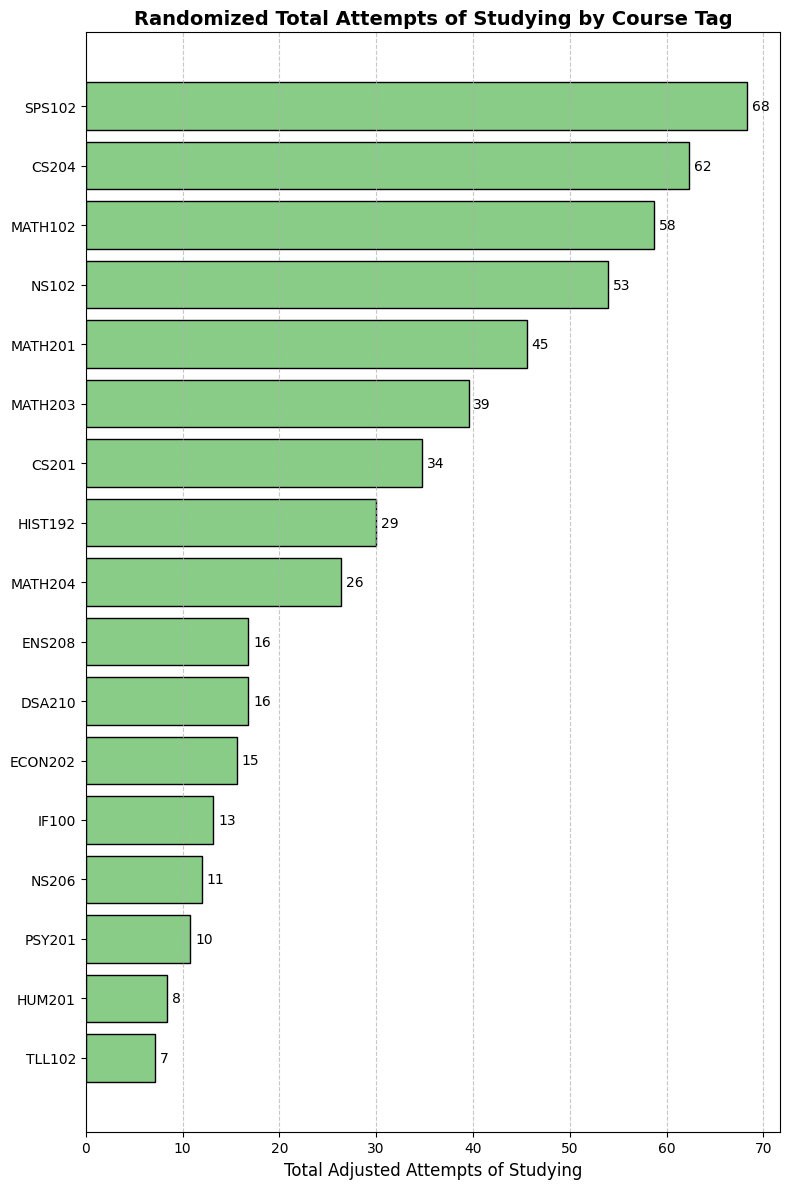

Plot saved to /content/tag_ranking_study_adjusted.png


In [ ]:

daily_tag_summary_path = '/content/daily_tag_summary.csv'
tag_data = pd.read_csv(daily_tag_summary_path)

tag_data['Tag'] = tag_data['Tag'].replace({'SPS102 1': 'SPS102', 'CS204 1': 'CS204', 'SPS': 'SPS102'})

unset_data = tag_data[tag_data['Tag'] == 'Unset']
study_data = tag_data[tag_data['Tag'] == 'Study']
non_unset_data = tag_data[~tag_data['Tag'].isin(['Unset', 'Study', 'English', 'writing stories', 'studying italian'])]


excluded_tags = ['CDP', 'PROJ201']
non_unset_data = non_unset_data[~non_unset_data['Tag'].isin(excluded_tags)]


total_unset_sessions = unset_data['study_sessions'].sum() if not unset_data.empty else 0
total_study_sessions = study_data['study_sessions'].sum() if not study_data.empty else 0

tag_summary = non_unset_data.groupby('Tag')['study_sessions'].sum().reset_index()
tag_summary.columns = ['Tag', 'Total Attempts']


total_attempts_excluding_unset_and_study = tag_summary['Total Attempts'].sum()


tag_summary['Weight'] = tag_summary['Total Attempts'] / total_attempts_excluding_unset_and_study
tag_summary['Distributed Unset Attempts'] = tag_summary['Weight'] * total_unset_sessions
tag_summary['Distributed Study Attempts'] = tag_summary['Weight'] * total_study_sessions


tag_summary['Adjusted Total Attempts'] = (
    tag_summary['Total Attempts'] +
    tag_summary['Distributed Unset Attempts'] +
    tag_summary['Distributed Study Attempts']
)


tag_summary = tag_summary.sort_values(by='Adjusted Total Attempts', ascending=False)


plt.figure(figsize=(8, 12))
bars = plt.barh(tag_summary['Tag'], tag_summary['Adjusted Total Attempts'], color='#88CC88', edgecolor='black')
plt.xlabel('Total Adjusted Attempts of Studying', fontsize=12)
plt.title('Randomized Total Attempts of Studying by Course Tag', fontsize=14, weight='bold')


for bar, value in zip(bars, tag_summary['Adjusted Total Attempts']):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{int(value)}', va='center', ha='left', fontsize=10, color='black')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()


output_dir = "/content/"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "tag_ranking_study_adjusted.png")
plt.savefig(output_path, dpi=300)
plt.show()
print(f"Plot saved to {output_path}")

**2) Calculating Total Hours Spent on Each Course**

Below, you may see the code for calculating the aggregately spent hour on each course that I have recorded on my app so far.

(What a shame is that I was not able to use the my ongoing recordings on DSA210 and have the analysis better..)

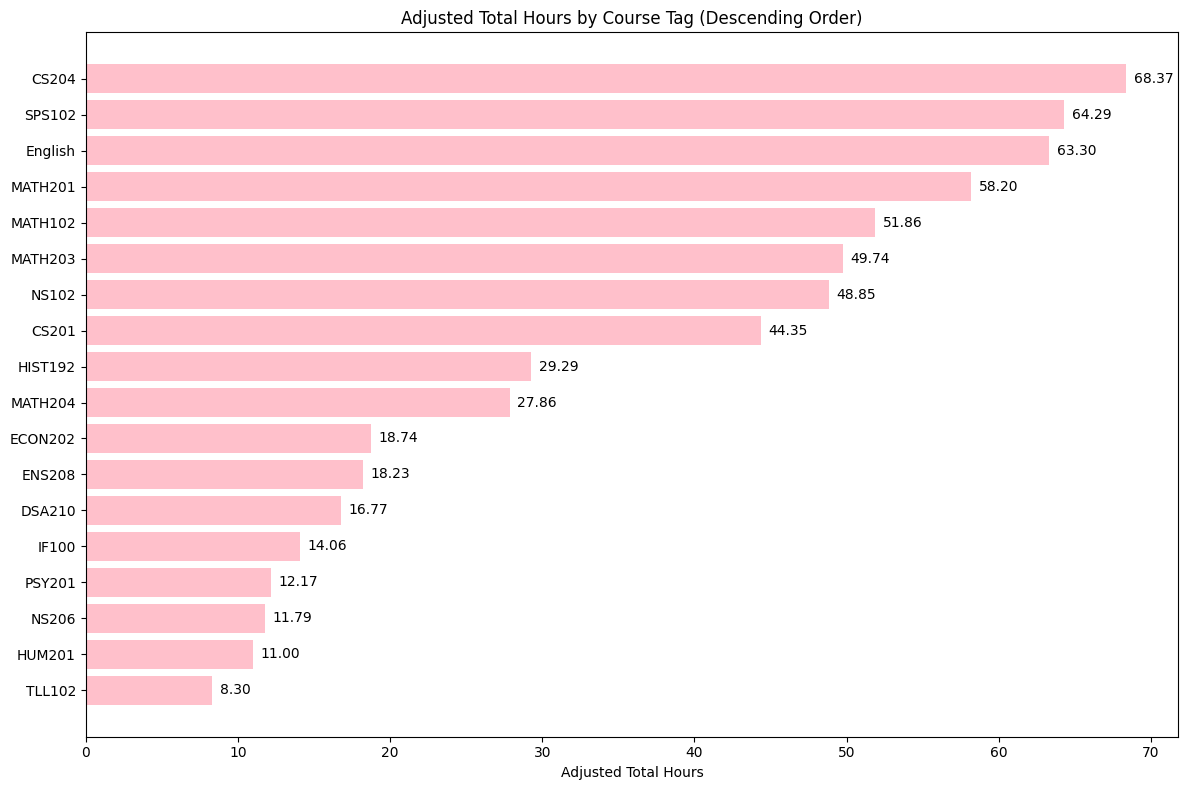

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

file_path = '/content/Cleaned_and_Adjusted_Study_Data.csv'
data = pd.read_csv(file_path)

data['Start Time'] = pd.to_datetime(data['Start Time'], errors='coerce')
data['End Time'] = pd.to_datetime(data['End Time'], errors='coerce')

excluded_tags = ['CDP', 'PROJ201', "studying italian", "writing stories"]
data = data[~data['Tag'].isin(excluded_tags)]

data['Duration (hours)'] = (data['End Time'] - data['Start Time']).dt.total_seconds() / 3600
data['Tag'] = data['Tag'].replace({'SPS': 'SPS102', 'SPS102 1': 'SPS102', 'CS204 1': 'CS204'})

merged_data = data.groupby('Tag')['Duration (hours)'].sum().reset_index()
merged_data.columns = ['Tag', 'Total Hours']
unset_hours = merged_data.loc[merged_data['Tag'] == 'Unset', 'Total Hours'].values[0] if 'Unset' in merged_data['Tag'].values else 0
study_hours = merged_data.loc[merged_data['Tag'] == 'Study', 'Total Hours'].values[0] if 'Study' in merged_data['Tag'].values else 0

filtered_data = merged_data[~merged_data['Tag'].isin(['Unset', 'Study'])].copy()
total_hours_excluding_unset_and_study = filtered_data['Total Hours'].sum()

filtered_data['Weight'] = filtered_data['Total Hours'] / total_hours_excluding_unset_and_study
filtered_data['Distributed Unset Hours'] = filtered_data['Weight'] * unset_hours
filtered_data['Distributed Study Hours'] = filtered_data['Weight'] * study_hours

filtered_data['Adjusted Total Hours'] = (
    filtered_data['Total Hours'] +
    filtered_data['Distributed Unset Hours'] +
    filtered_data['Distributed Study Hours'] )

filtered_data = filtered_data.sort_values(by='Adjusted Total Hours', ascending=True)

final_data = filtered_data[['Tag', 'Total Hours', 'Distributed Unset Hours', 'Distributed Study Hours', 'Adjusted Total Hours']]


plt.figure(figsize=(12, 8))
plt.barh(final_data['Tag'], final_data['Adjusted Total Hours'], color='pink')
plt.xlabel('Adjusted Total Hours')
plt.title('Adjusted Total Hours by Course Tag (Descending Order)')

for index, value in enumerate(final_data['Adjusted Total Hours']):
    plt.text(value + 0.5, index, f'{value:.2f}', va='center')

plt.tight_layout()
output_chart_path = '/content/Adjusted_Total_Hours_by_Tag_Sorted.png'
plt.savefig(output_chart_path)
plt.show()

**3) Calculating "Attention Span"**

After calculating the number of times that I have sat on the table and the total hours of studying, I thought it might be fun to calculate my attention span. I calculated it by dividing the total hours of studying by the study-attempts.

Below, you may check the codes for this additional data.

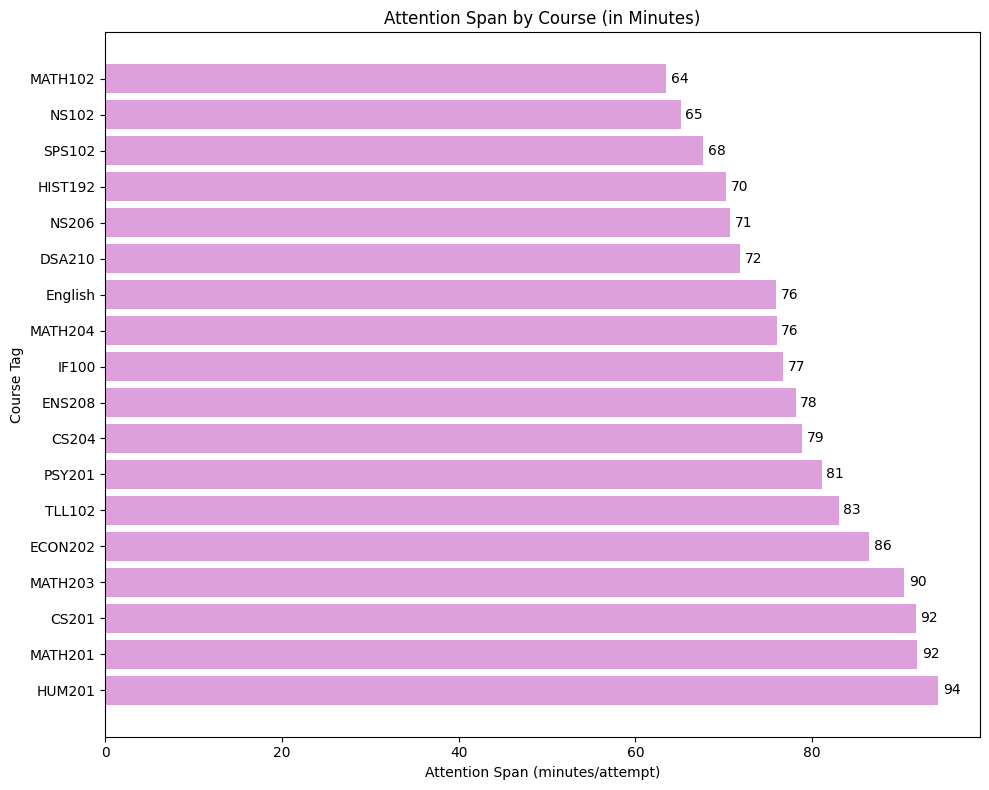

Analysis saved to /content/attention_span_analysis.csv
Plot saved to /content/attention_span_plot_minutes.png


In [ ]:

file_path = '/content/Cleaned_and_Adjusted_Study_Data.csv'
data = pd.read_csv(file_path)

data['Start Time'] = pd.to_datetime(data['Start Time'], errors='coerce')
data['End Time'] = pd.to_datetime(data['End Time'], errors='coerce')
data['Duration (hours)'] = (data['End Time'] - data['Start Time']).dt.total_seconds() / 3600

excluded_tags = ['CDP', 'PROJ201', "studying italian", "writing stories"]
data = data[~data['Tag'].isin(excluded_tags)]
data['Tag'] = data['Tag'].replace({'SPS': 'SPS102', 'SPS102 1': 'SPS102', 'CS204 1': 'CS204'})

merged_data = data.groupby('Tag')[['Duration (hours)']].sum().reset_index()
merged_data['study_sessions'] = data.groupby('Tag').size().values
merged_data.columns = ['Tag', 'Total Hours', 'Study Sessions']

unset_data = merged_data[merged_data['Tag'] == 'Unset']
study_data = merged_data[merged_data['Tag'] == 'Study']

unset_hours = unset_data['Total Hours'].sum() if not unset_data.empty else 0
unset_sessions = unset_data['Study Sessions'].sum() if not unset_data.empty else 0
study_hours = study_data['Total Hours'].sum() if not study_data.empty else 0
study_sessions = study_data['Study Sessions'].sum() if not study_data.empty else 0

filtered_data = merged_data[~merged_data['Tag'].isin(['Unset', 'Study'])].copy()
filtered_data['Weight'] = filtered_data['Total Hours'] / filtered_data['Total Hours'].sum()
filtered_data['Distributed Unset Hours'] = filtered_data['Weight'] * unset_hours
filtered_data['Distributed Study Hours'] = filtered_data['Weight'] * study_hours
filtered_data['Distributed Unset Sessions'] = filtered_data['Weight'] * unset_sessions
filtered_data['Distributed Study Sessions'] = filtered_data['Weight'] * study_sessions

filtered_data['Adjusted Total Hours'] = (
    filtered_data['Total Hours'] +
    filtered_data['Distributed Unset Hours'] +
    filtered_data['Distributed Study Hours']  )

filtered_data['Adjusted Study Sessions'] = (
    filtered_data['Study Sessions'] +
    filtered_data['Distributed Unset Sessions'] +
    filtered_data['Distributed Study Sessions'] )

filtered_data['Attention Span (minutes/attempt)'] = (
    (filtered_data['Adjusted Total Hours'] / filtered_data['Adjusted Study Sessions']) * 60 )

filtered_data = filtered_data.sort_values(by='Attention Span (minutes/attempt)', ascending=False)

output_path = '/content/attention_span_analysis.csv'
filtered_data.to_csv(output_path, index=False)

plt.figure(figsize=(10, 8))
bars = plt.barh(filtered_data['Tag'], filtered_data['Attention Span (minutes/attempt)'], color='plum')
plt.xlabel('Attention Span (minutes/attempt)')
plt.ylabel('Course Tag')
plt.title('Attention Span by Course (in Minutes)')

for bar, value in zip(bars, filtered_data['Attention Span (minutes/attempt)']):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{int(round(value))}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plot_output_path = '/content/attention_span_plot_minutes.png'
plt.savefig(plot_output_path)
plt.show()

print(f"Analysis saved to {output_path}")
print(f"Plot saved to {plot_output_path}")

**4) Most Focused Hours and the Most Focused Days of the Week**

Below, you will see the most focused hours for each course, and the most focused days of the week for that particular course.


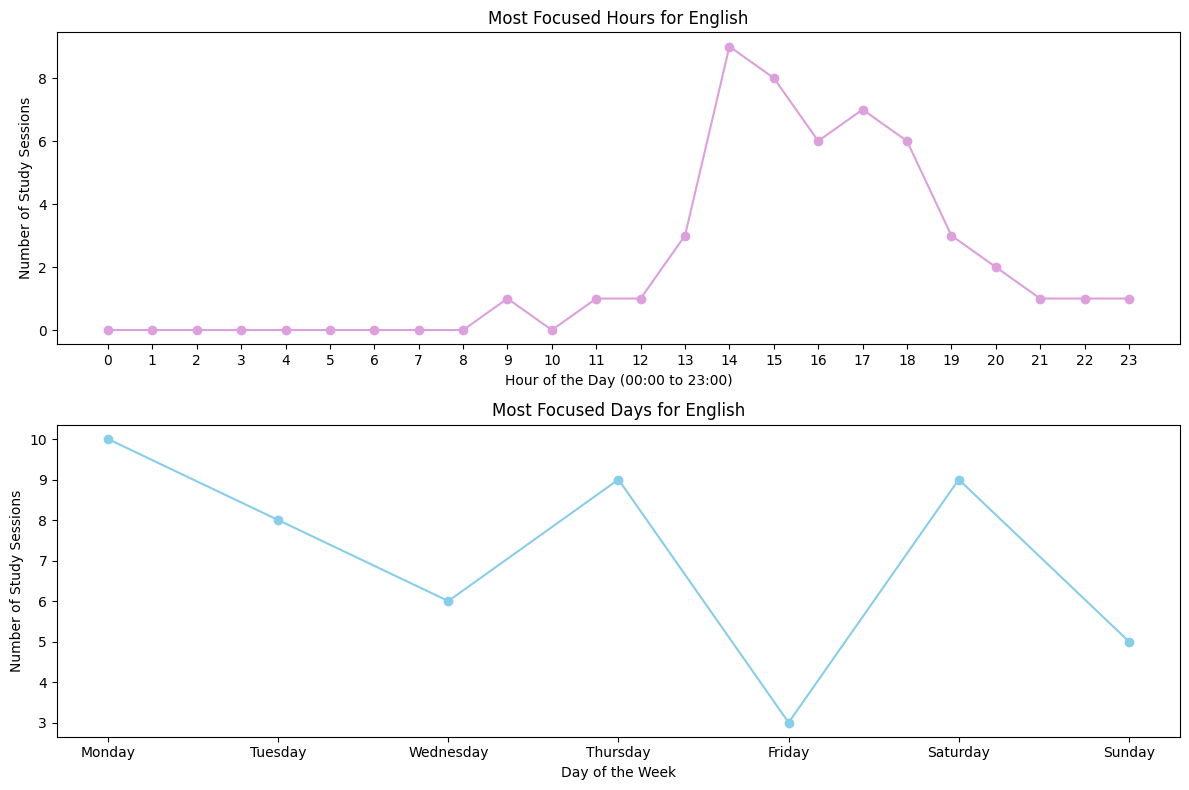

Graph for English saved to /content/focused_hours_and_days_English.png


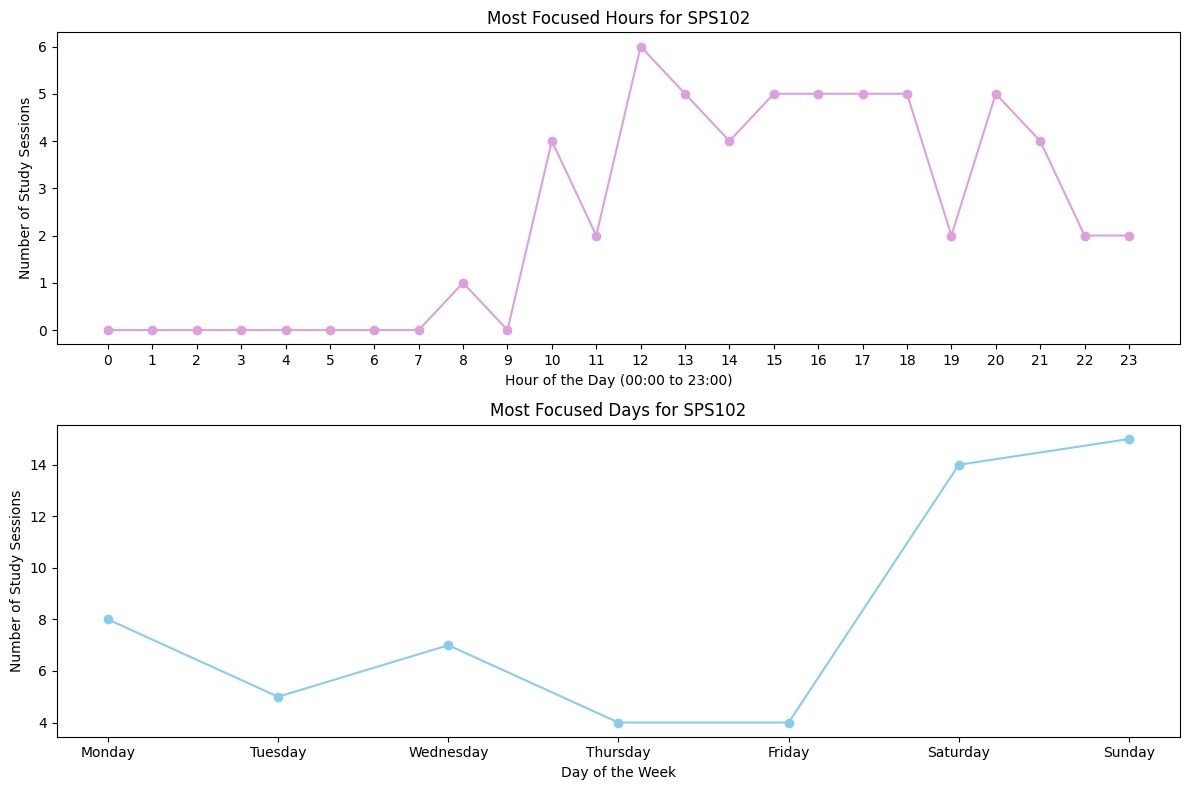

Graph for SPS102 saved to /content/focused_hours_and_days_SPS102.png


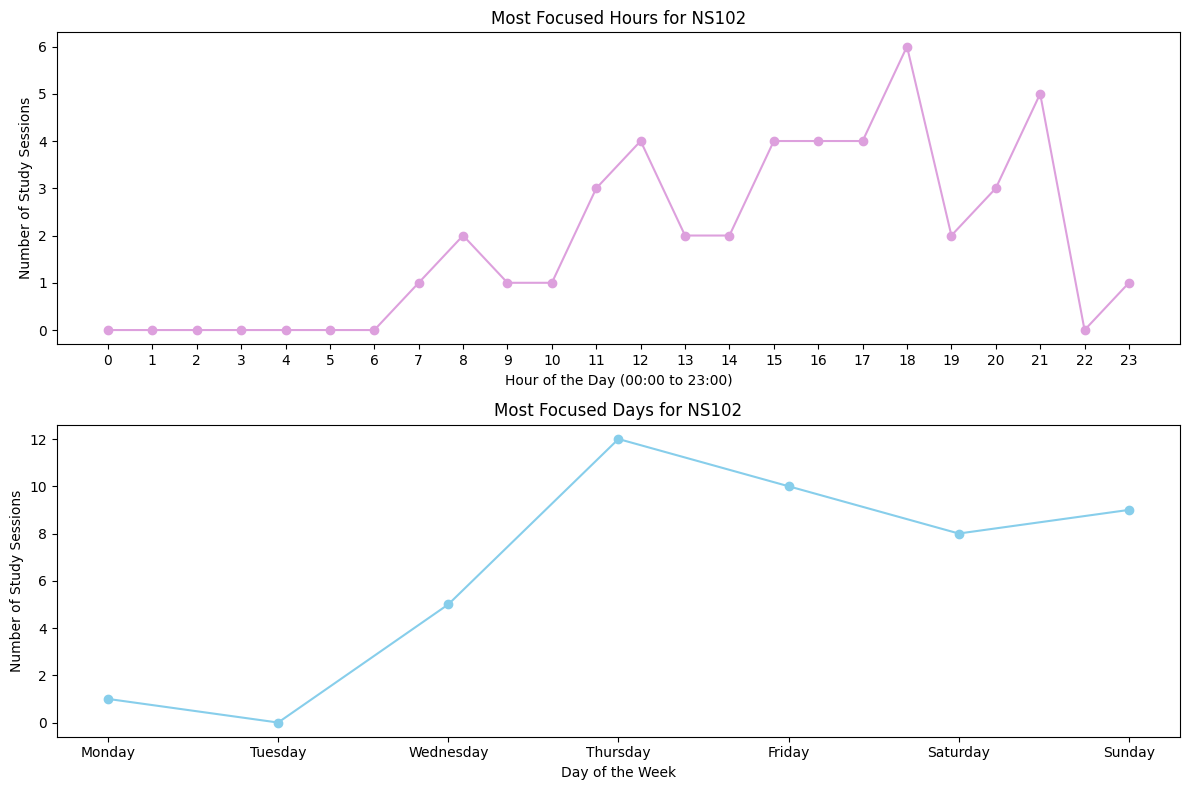

Graph for NS102 saved to /content/focused_hours_and_days_NS102.png


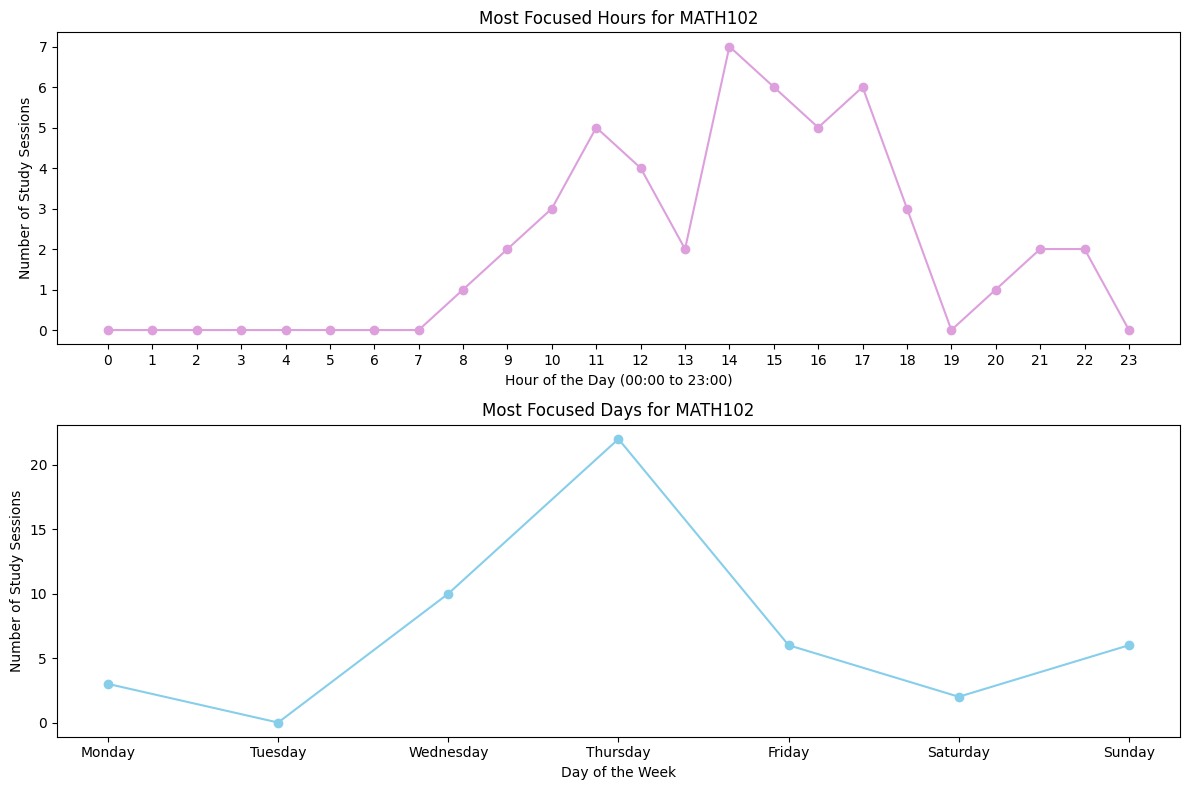

Graph for MATH102 saved to /content/focused_hours_and_days_MATH102.png


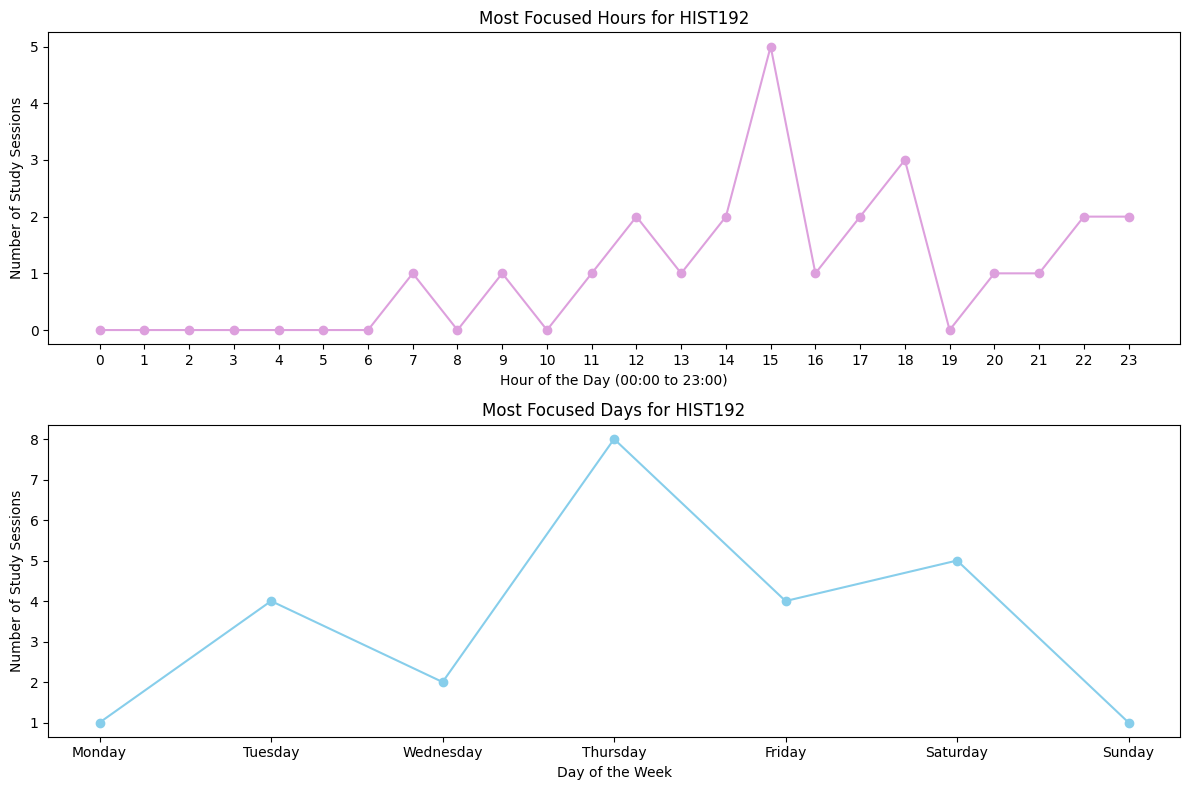

Graph for HIST192 saved to /content/focused_hours_and_days_HIST192.png


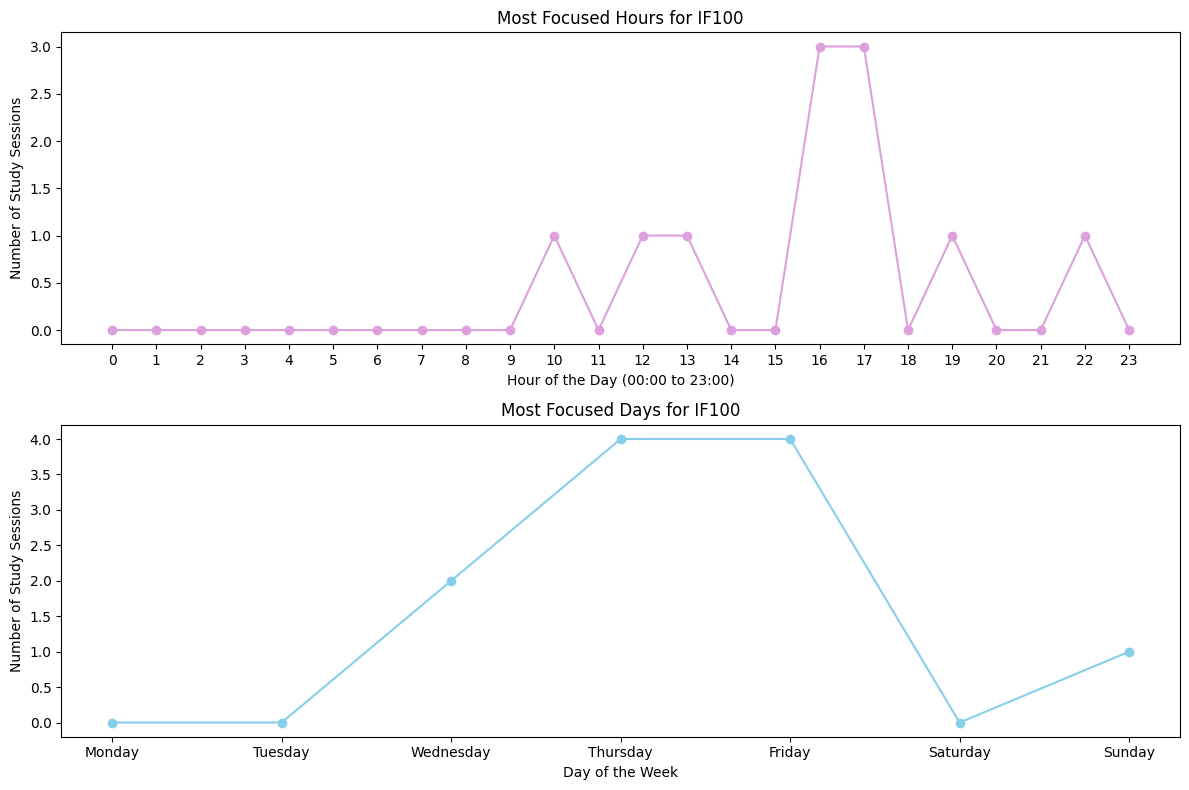

Graph for IF100 saved to /content/focused_hours_and_days_IF100.png


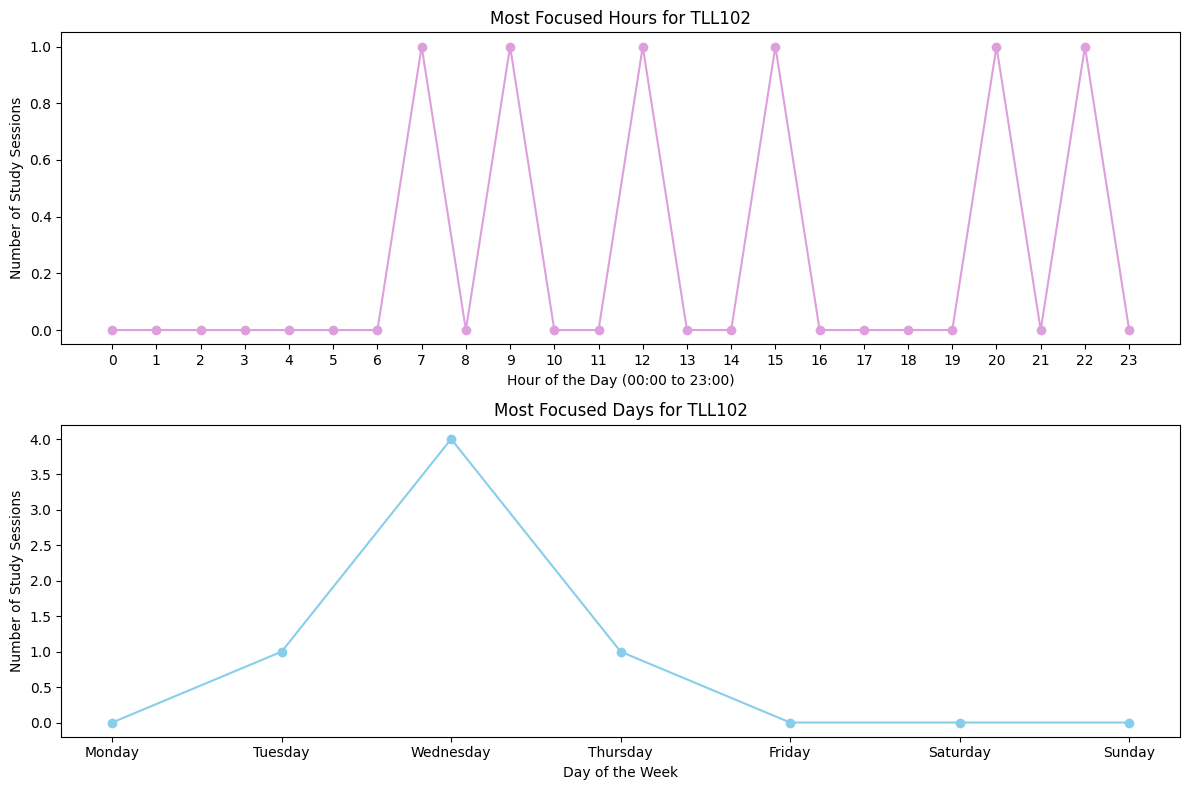

Graph for TLL102 saved to /content/focused_hours_and_days_TLL102.png


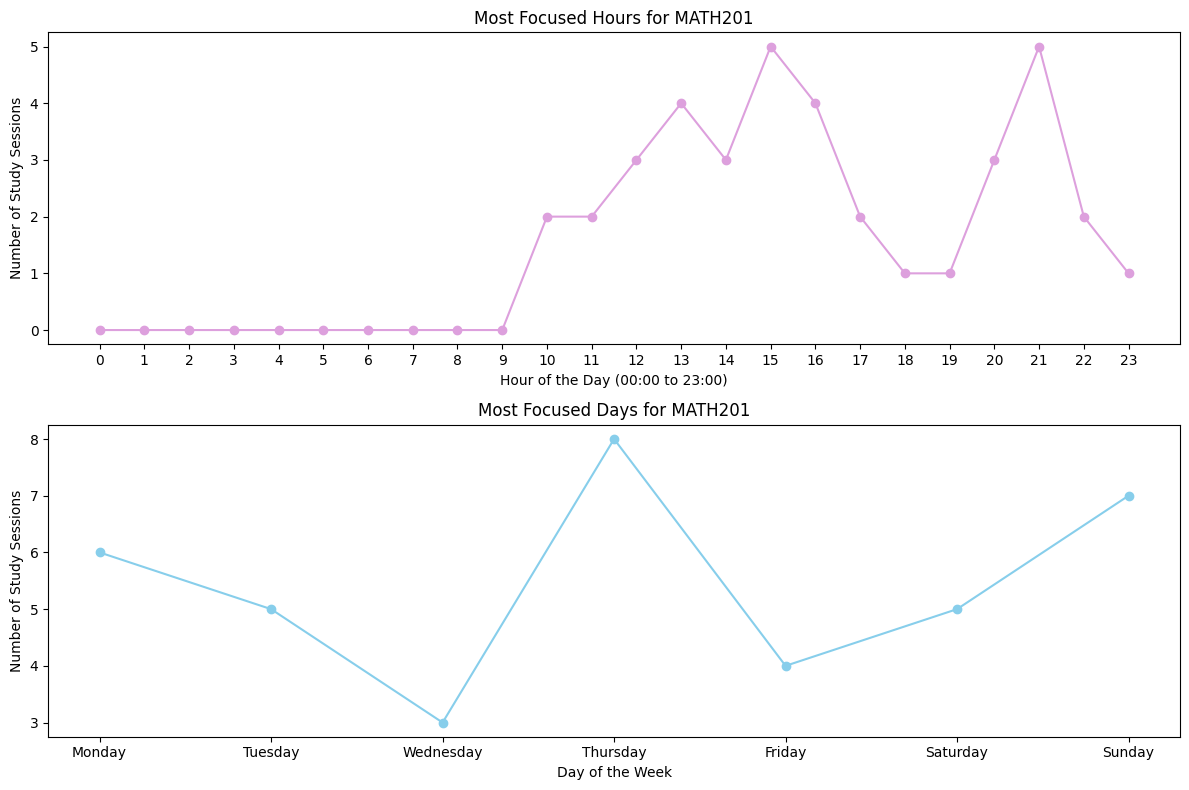

Graph for MATH201 saved to /content/focused_hours_and_days_MATH201.png


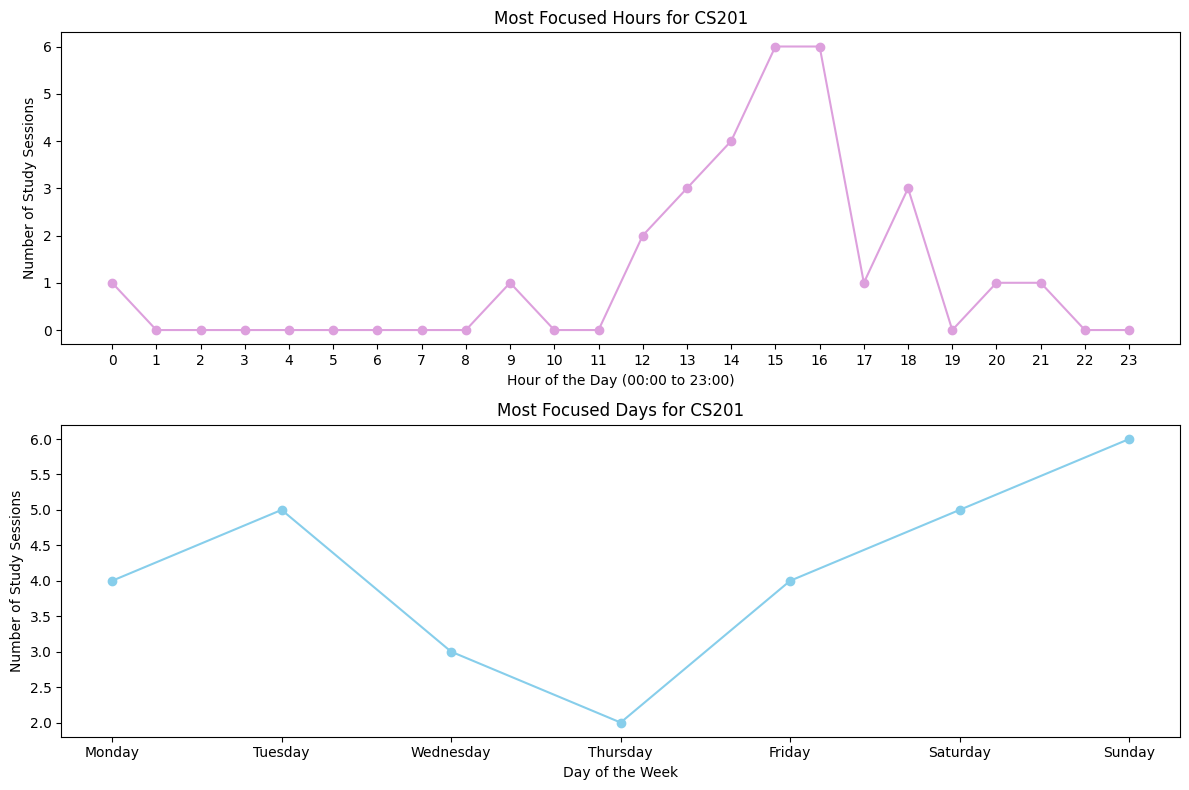

Graph for CS201 saved to /content/focused_hours_and_days_CS201.png


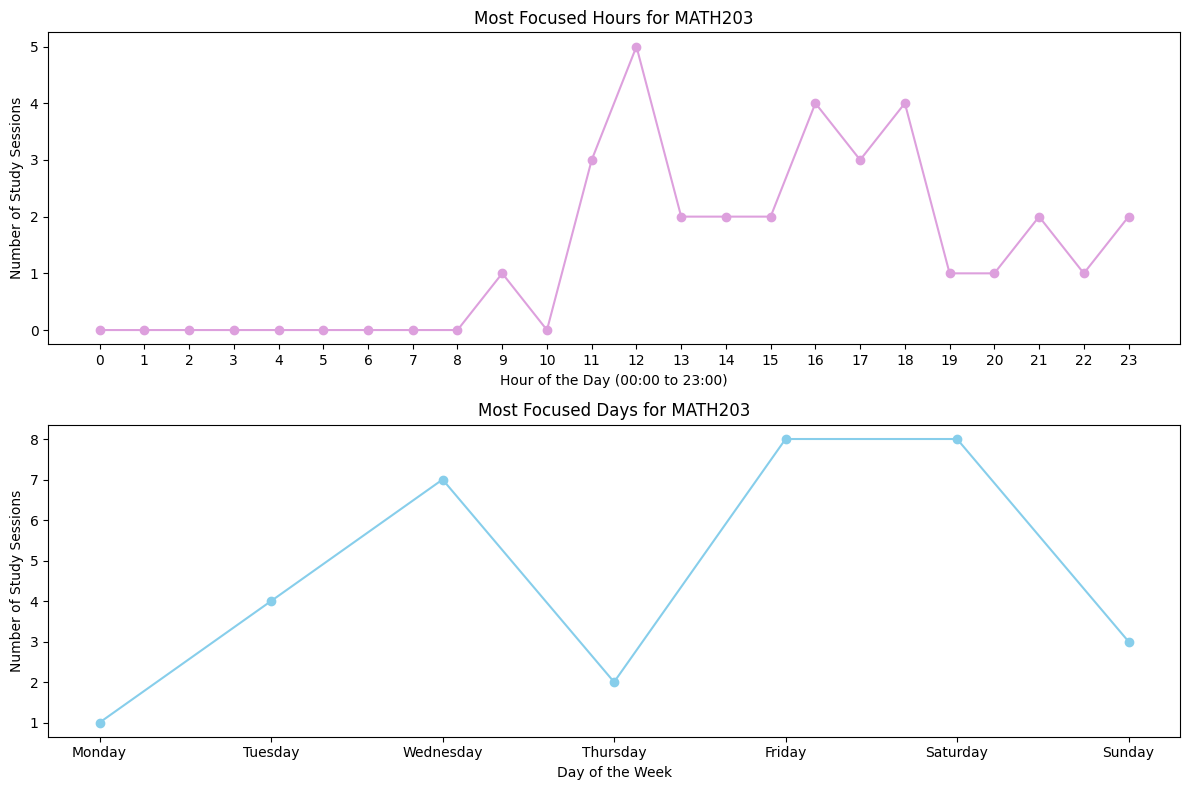

Graph for MATH203 saved to /content/focused_hours_and_days_MATH203.png


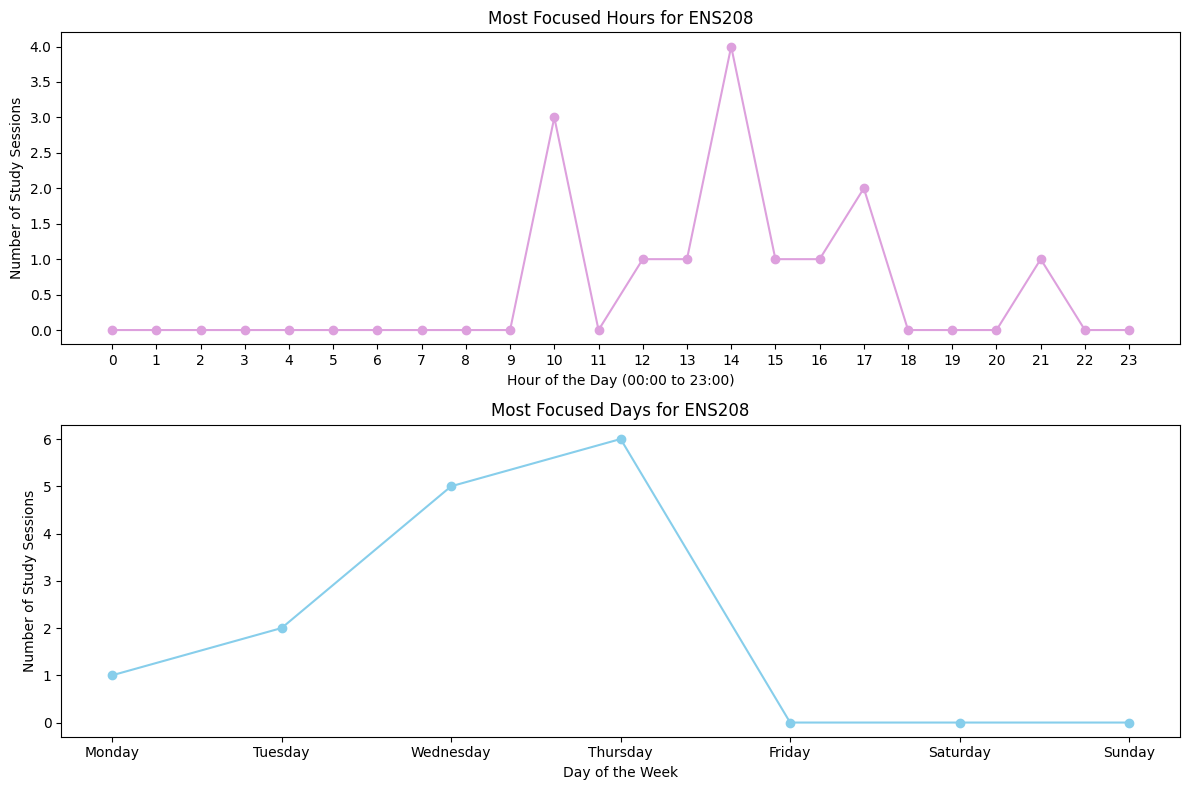

Graph for ENS208 saved to /content/focused_hours_and_days_ENS208.png


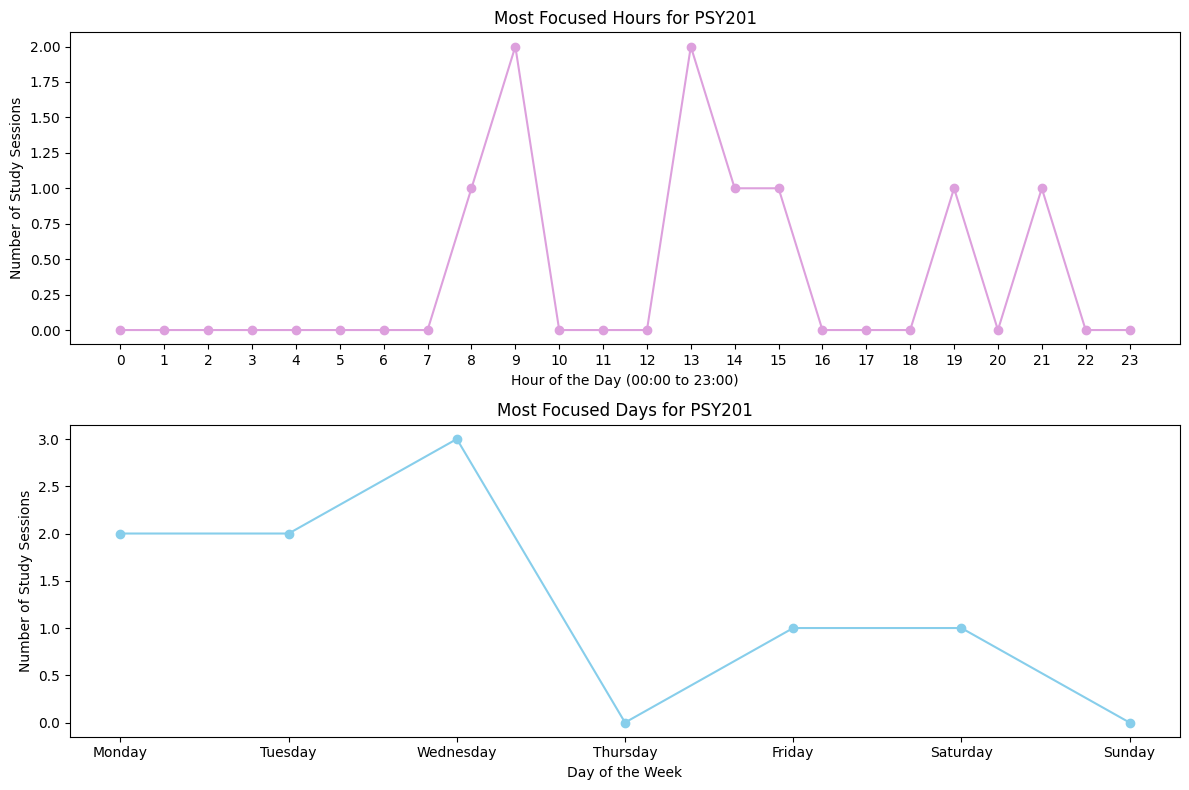

Graph for PSY201 saved to /content/focused_hours_and_days_PSY201.png


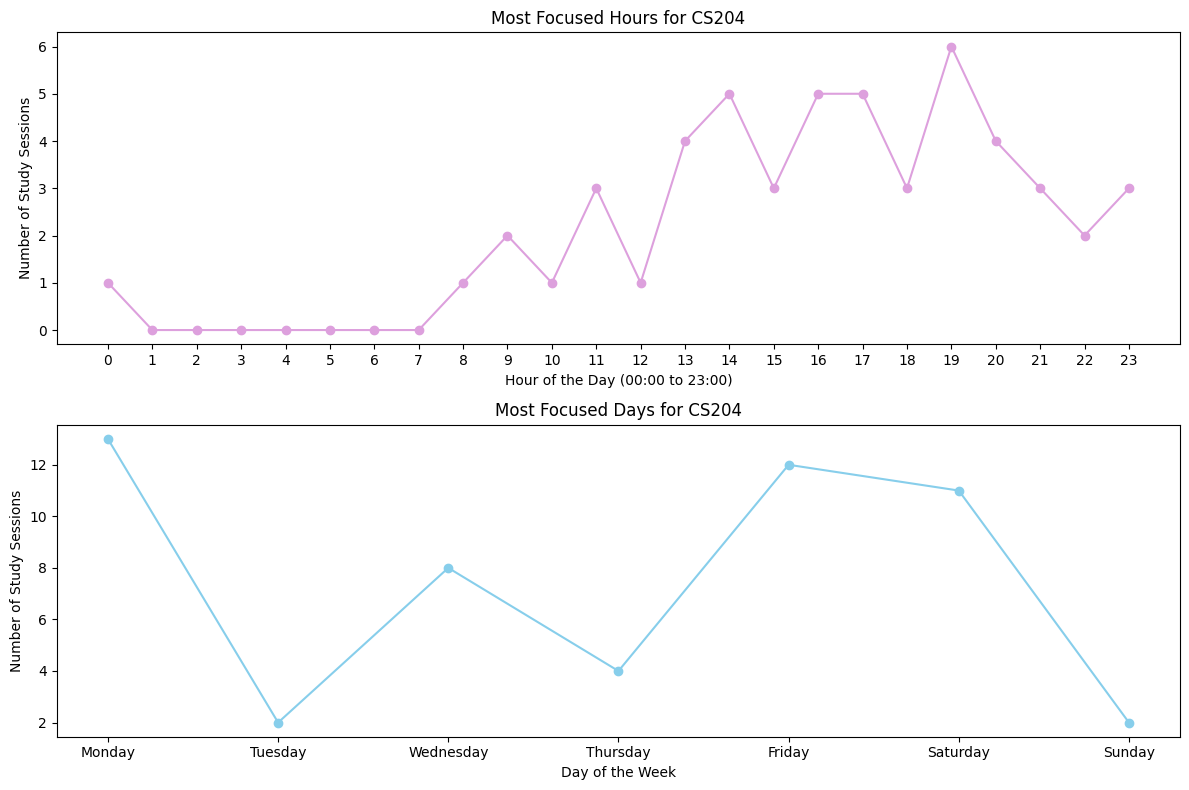

Graph for CS204 saved to /content/focused_hours_and_days_CS204.png


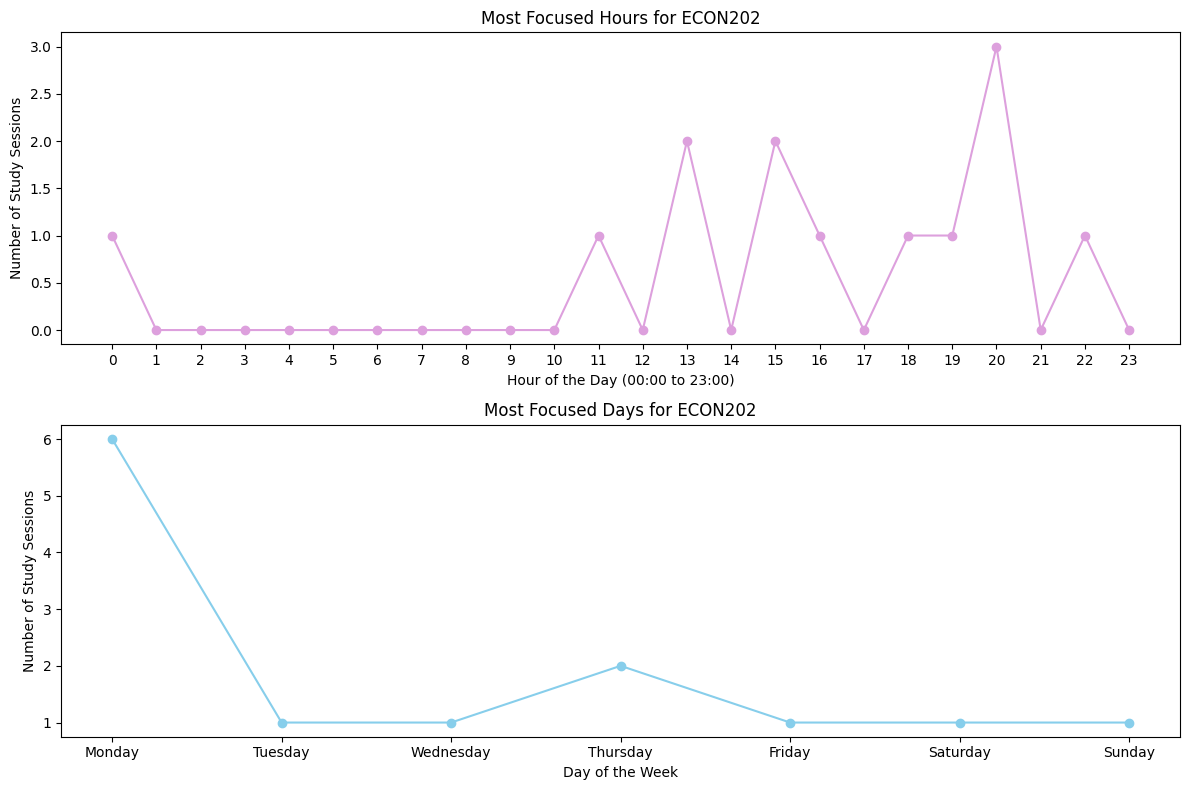

Graph for ECON202 saved to /content/focused_hours_and_days_ECON202.png


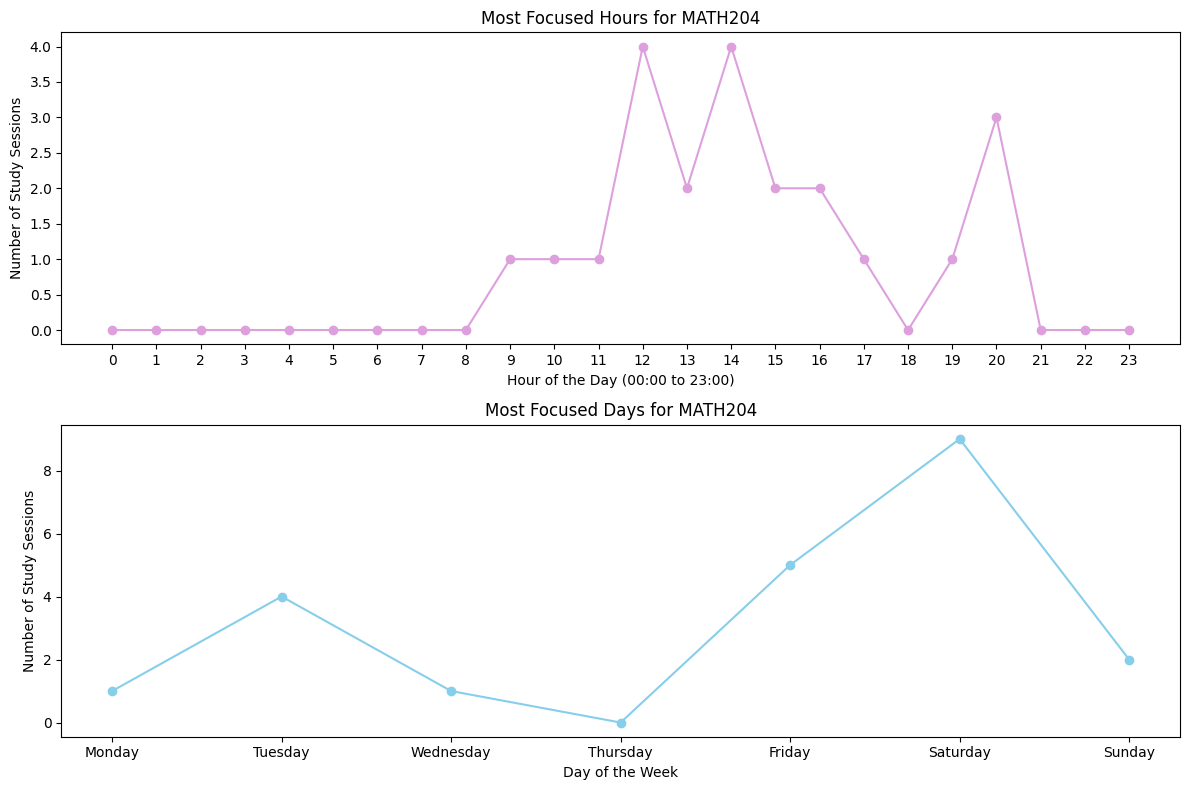

Graph for MATH204 saved to /content/focused_hours_and_days_MATH204.png


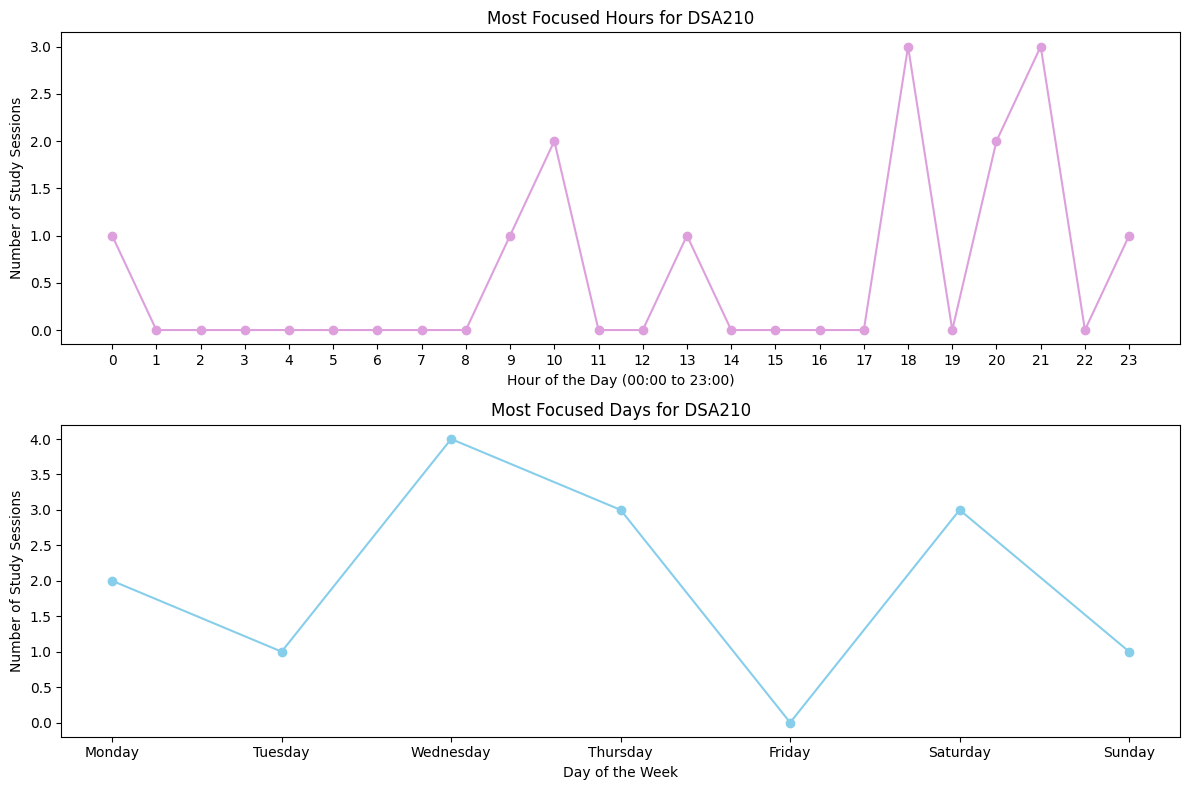

Graph for DSA210 saved to /content/focused_hours_and_days_DSA210.png


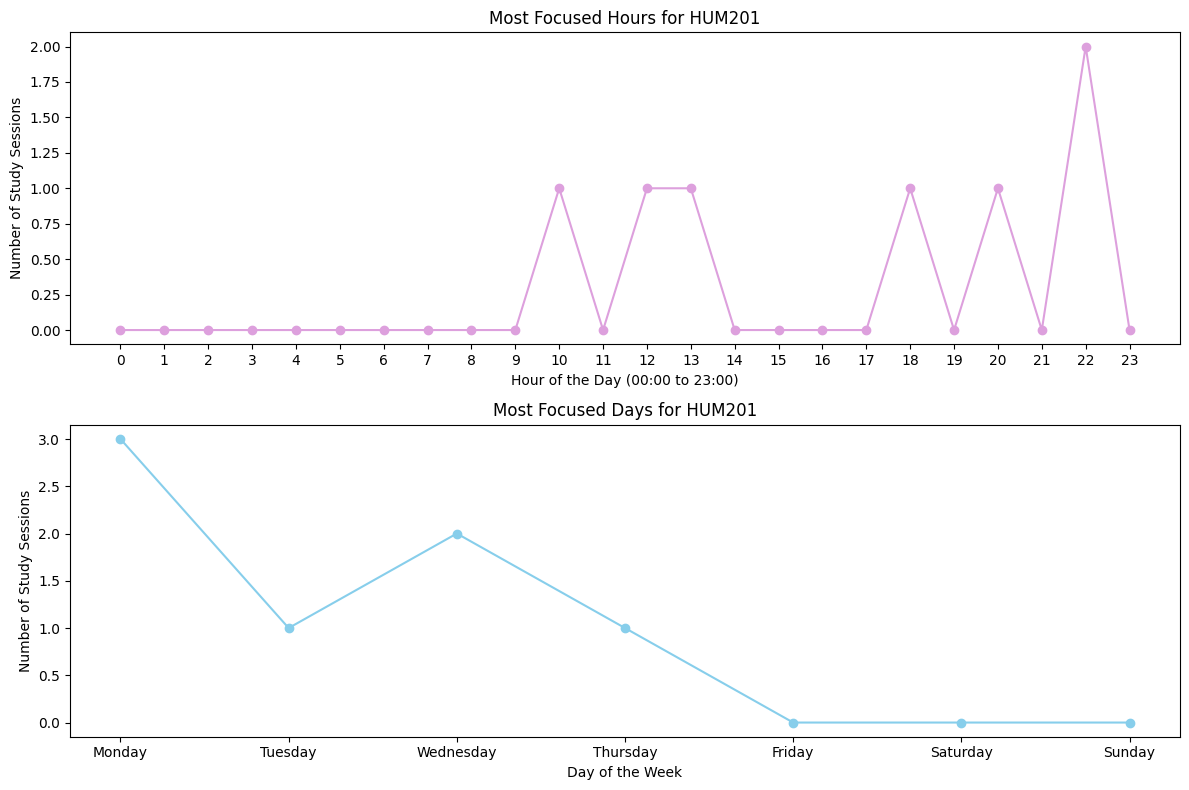

Graph for HUM201 saved to /content/focused_hours_and_days_HUM201.png


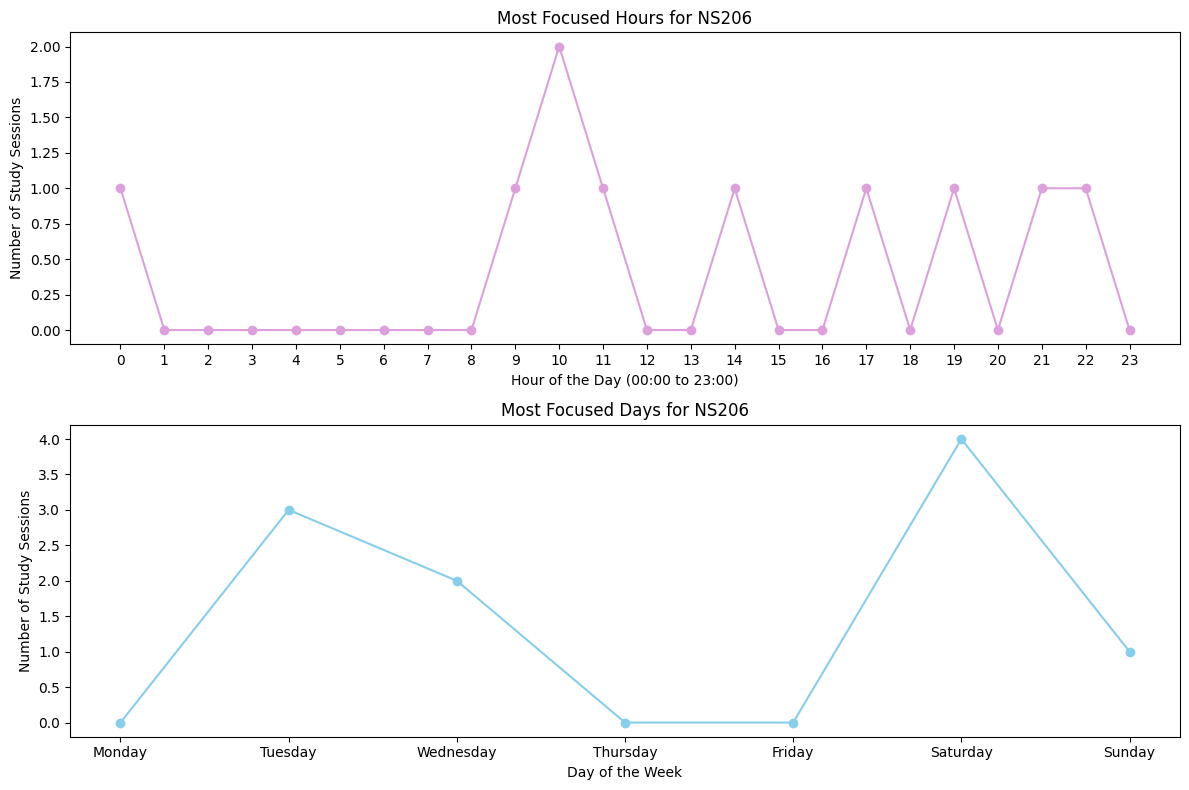

Graph for NS206 saved to /content/focused_hours_and_days_NS206.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/Cleaned_and_Adjusted_Study_Data.csv'
attention_file = '/content/attention_span_analysis.csv'

data = pd.read_csv(file_path)
attention_data = pd.read_csv(attention_file)

data['Start Time'] = pd.to_datetime(data['Start Time'], format='ISO8601', errors='coerce')
data['End Time'] = pd.to_datetime(data['End Time'], format='ISO8601', errors='coerce')

if data['Start Time'].isnull().any() or data['End Time'].isnull().any():
    print("Warning: Some datetime entries could not be parsed and will be dropped.")
    data = data.dropna(subset=['Start Time', 'End Time'])

if 'Duration (hours)' not in data.columns:
    data['Duration (hours)'] = (data['End Time'] - data['Start Time']).dt.total_seconds() / 3600

excluded_tags = ['CDP', 'PROJ201', 'studying italian', 'writing stories']
data = data[~data['Tag'].isin(excluded_tags)]

data['Tag'] = data['Tag'].replace({
    'SPS': 'SPS102',
    'SPS102 1': 'SPS102',
    'CS204 1': 'CS204'
})

unset_data = data[data['Tag'] == 'Unset']
study_data = data[data['Tag'] == 'Study']

total_unset_hours = unset_data['Duration (hours)'].sum()
total_unset_sessions = len(unset_data)

total_study_hours = study_data['Duration (hours)'].sum()
total_study_sessions = len(study_data)

attention_data['Weight'] = attention_data['Total Hours'] / attention_data['Total Hours'].sum()
attention_data['Distributed Unset Hours'] = attention_data['Weight'] * total_unset_hours
attention_data['Distributed Unset Sessions'] = attention_data['Weight'] * total_unset_sessions
attention_data['Distributed Study Hours'] = attention_data['Weight'] * total_study_hours
attention_data['Distributed Study Sessions'] = attention_data['Weight'] * total_study_sessions

for idx, row in attention_data.iterrows():
    tag = row['Tag']
    hours_to_add = row['Distributed Unset Hours'] + row['Distributed Study Hours']
    sessions_to_add = row['Distributed Unset Sessions'] + row['Distributed Study Sessions']

    if tag in data['Tag'].values:
        data.loc[data['Tag'] == tag, 'Duration (hours)'] += hours_to_add
    else:
        new_row = {
            'Tag': tag,
            'Duration (hours)': hours_to_add,
            'study_sessions': sessions_to_add
        }
        new_row_df = pd.DataFrame([new_row])
        data = pd.concat([data, new_row_df], ignore_index=True)


data = data[~data['Tag'].isin(['Unset', 'Study'])]


data['Hour'] = data['Start Time'].dt.hour
data['Day of Week'] = data['Start Time'].dt.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

tags = data['Tag'].unique()
for tag in tags:
    tag_data = data[data['Tag'] == tag]

    if tag_data.empty:
        continue

    hourly_counts = tag_data['Hour'].value_counts().reindex(range(24), fill_value=0)
    daily_counts = tag_data['Day of Week'].value_counts().reindex(days_order, fill_value=0)

    if hourly_counts.sum() == 0 and daily_counts.sum() == 0:
        continue


    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(hourly_counts.index, hourly_counts.values, marker='o', color='plum')
    plt.title(f'Most Focused Hours for {tag}')
    plt.xlabel('Hour of the Day (00:00 to 23:00)')
    plt.ylabel('Number of Study Sessions')
    plt.xticks(range(0, 24))

    plt.subplot(2, 1, 2)
    plt.plot(daily_counts.index, daily_counts.values, marker='o', color='skyblue')
    plt.title(f'Most Focused Days for {tag}')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Study Sessions')
    plt.tight_layout()


    output_path = f'/content/focused_hours_and_days_{tag}.png'
    plt.savefig(output_path)
    plt.show()
    print(f'Graph for {tag} saved to {output_path}')

# EXPLORING INSTAGRAM DATA


**1) Peak Hours of Procrastination**

Below, I have calculated my time spent on Instagram by counting the likes on a 24-hour based bar chart.

I have categorized the data into my academic periods.


Hourly Likes for Feb 2023 - June 2023:
00:00–00:59 => 35 likes
01:00–01:59 => 33 likes
02:00–02:59 => 0 likes
03:00–03:59 => 0 likes
04:00–04:59 => 0 likes
05:00–05:59 => 0 likes
06:00–06:59 => 1 likes
07:00–07:59 => 2 likes
08:00–08:59 => 5 likes
09:00–09:59 => 8 likes
10:00–10:59 => 15 likes
11:00–11:59 => 28 likes
12:00–12:59 => 43 likes
13:00–13:59 => 35 likes
14:00–14:59 => 27 likes
15:00–15:59 => 13 likes
16:00–16:59 => 22 likes
17:00–17:59 => 23 likes
18:00–18:59 => 30 likes
19:00–19:59 => 35 likes
20:00–20:59 => 31 likes
21:00–21:59 => 31 likes
22:00–22:59 => 35 likes
23:00–23:59 => 50 likes


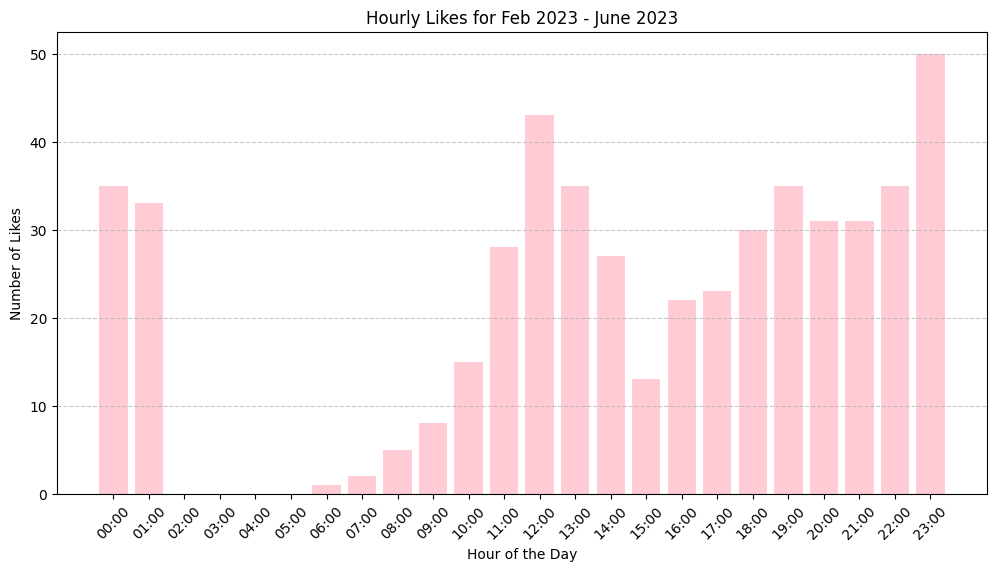

Chart saved to /content/hourly_likes_Feb_2023___June_2023.png

Hourly Likes for Oct 2023 - Jan 2024:
00:00–00:59 => 106 likes
01:00–01:59 => 26 likes
02:00–02:59 => 0 likes
03:00–03:59 => 0 likes
04:00–04:59 => 0 likes
05:00–05:59 => 2 likes
06:00–06:59 => 1 likes
07:00–07:59 => 0 likes
08:00–08:59 => 9 likes
09:00–09:59 => 20 likes
10:00–10:59 => 41 likes
11:00–11:59 => 43 likes
12:00–12:59 => 54 likes
13:00–13:59 => 23 likes
14:00–14:59 => 54 likes
15:00–15:59 => 21 likes
16:00–16:59 => 33 likes
17:00–17:59 => 52 likes
18:00–18:59 => 60 likes
19:00–19:59 => 26 likes
20:00–20:59 => 68 likes
21:00–21:59 => 33 likes
22:00–22:59 => 43 likes
23:00–23:59 => 65 likes


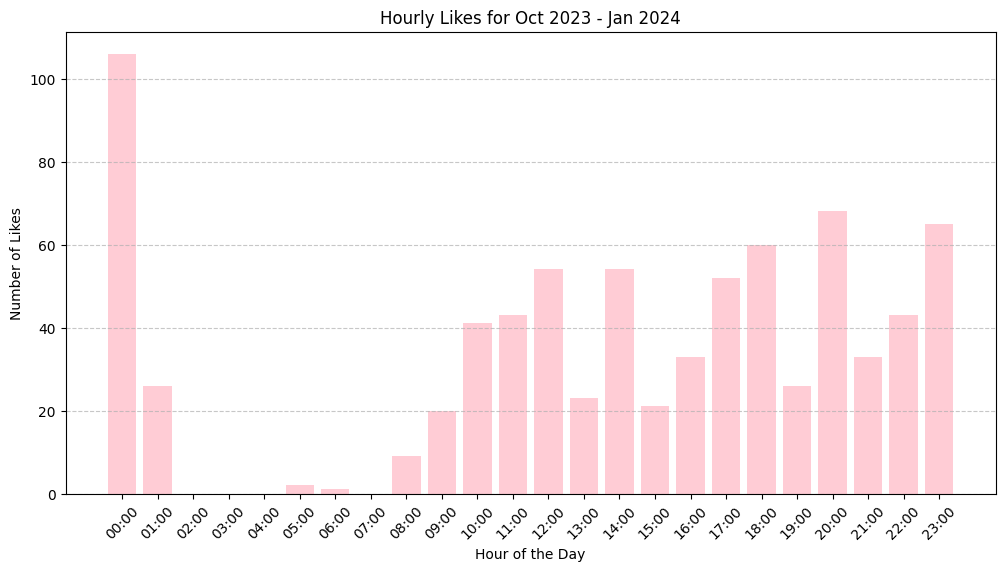

Chart saved to /content/hourly_likes_Oct_2023___Jan_2024.png

Hourly Likes for Feb 2024 - June 2024:
00:00–00:59 => 446 likes
01:00–01:59 => 187 likes
02:00–02:59 => 31 likes
03:00–03:59 => 3 likes
04:00–04:59 => 2 likes
05:00–05:59 => 1 likes
06:00–06:59 => 1 likes
07:00–07:59 => 5 likes
08:00–08:59 => 9 likes
09:00–09:59 => 67 likes
10:00–10:59 => 107 likes
11:00–11:59 => 95 likes
12:00–12:59 => 142 likes
13:00–13:59 => 111 likes
14:00–14:59 => 97 likes
15:00–15:59 => 91 likes
16:00–16:59 => 78 likes
17:00–17:59 => 84 likes
18:00–18:59 => 106 likes
19:00–19:59 => 76 likes
20:00–20:59 => 92 likes
21:00–21:59 => 103 likes
22:00–22:59 => 83 likes
23:00–23:59 => 206 likes


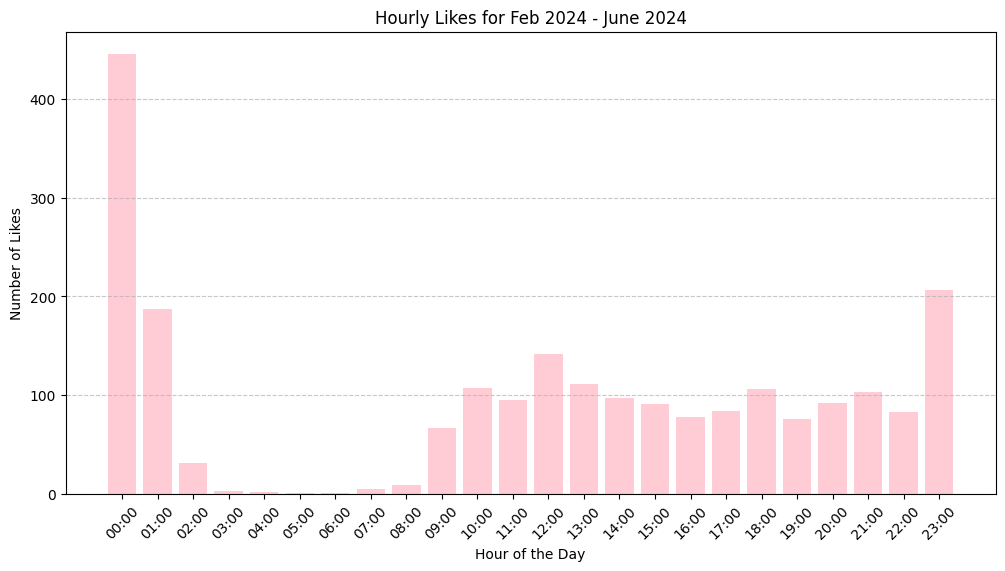

Chart saved to /content/hourly_likes_Feb_2024___June_2024.png

Hourly Likes for Oct 2024 - Now:
00:00–00:59 => 162 likes
01:00–01:59 => 135 likes
02:00–02:59 => 0 likes
03:00–03:59 => 0 likes
04:00–04:59 => 0 likes
05:00–05:59 => 0 likes
06:00–06:59 => 0 likes
07:00–07:59 => 2 likes
08:00–08:59 => 7 likes
09:00–09:59 => 64 likes
10:00–10:59 => 42 likes
11:00–11:59 => 42 likes
12:00–12:59 => 27 likes
13:00–13:59 => 16 likes
14:00–14:59 => 24 likes
15:00–15:59 => 48 likes
16:00–16:59 => 38 likes
17:00–17:59 => 45 likes
18:00–18:59 => 55 likes
19:00–19:59 => 64 likes
20:00–20:59 => 69 likes
21:00–21:59 => 28 likes
22:00–22:59 => 43 likes
23:00–23:59 => 96 likes


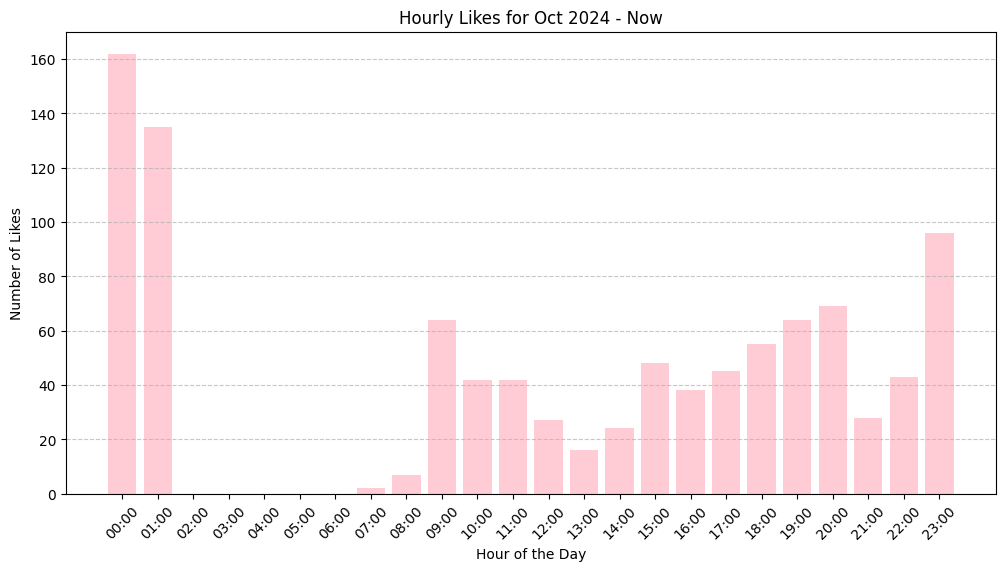

Chart saved to /content/hourly_likes_Oct_2024___Now.png


In [ ]:
processed_file_path = '/content/processed_likes.csv'

likes_df = pd.read_csv(processed_file_path, parse_dates=['timestamp'])
likes_df['hour'] = likes_df['timestamp'].dt.hour

academic_periods = {
    "Feb 2023 - June 2023": (pd.Timestamp("2023-02-01", tz='Europe/Istanbul'),
                             pd.Timestamp("2023-06-30", tz='Europe/Istanbul')),
    "Oct 2023 - Jan 2024": (pd.Timestamp("2023-10-01", tz='Europe/Istanbul'),
                            pd.Timestamp("2024-01-31", tz='Europe/Istanbul')),
    "Feb 2024 - June 2024": (pd.Timestamp("2024-02-01", tz='Europe/Istanbul'),
                             pd.Timestamp("2024-06-30", tz='Europe/Istanbul')),
    "Oct 2024 - Now": (pd.Timestamp("2024-10-01", tz='Europe/Istanbul'),
                       likes_df['timestamp'].max())}

for period, (start, end) in academic_periods.items():

    period_likes = likes_df[(likes_df['timestamp'] >= start) & (likes_df['timestamp'] <= end)]
    likes_count = Counter(period_likes['hour'])

    full_hours = list(range(24))
    likes_sorted = [likes_count.get(hour, 0) for hour in full_hours]

    print(f"\nHourly Likes for {period}:")
    for hour, count in zip(full_hours, likes_sorted):
        print(f"{hour:02d}:00–{hour:02d}:59 => {count} likes")

    plt.figure(figsize=(12, 6))
    plt.bar(full_hours, likes_sorted, color='pink', alpha=0.8)
    plt.xticks(full_hours, [f"{hour:02d}:00" for hour in full_hours], rotation=45)
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Likes")
    plt.title(f"Hourly Likes for {period}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    output_chart_path = f'/content/hourly_likes_{period.replace(" ", "_").replace("-", "_")}.png'
    plt.savefig(output_chart_path)
    plt.show()
    print(f"Chart saved to {output_chart_path}")

**2) Peak Days of Procrastination**

Below, I will explore the days that I use Instagram the most.


Graph saved for Feb 2023 - June 2023 at likes_by_day_Feb_2023___June_2023.png


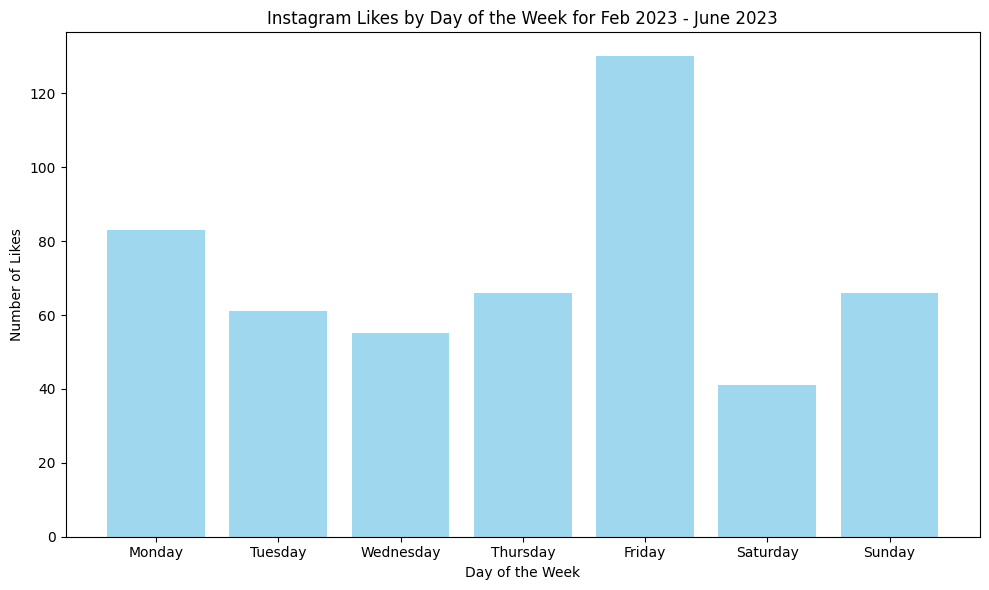

Graph saved for Oct 2023 - Jan 2024 at likes_by_day_Oct_2023___Jan_2024.png


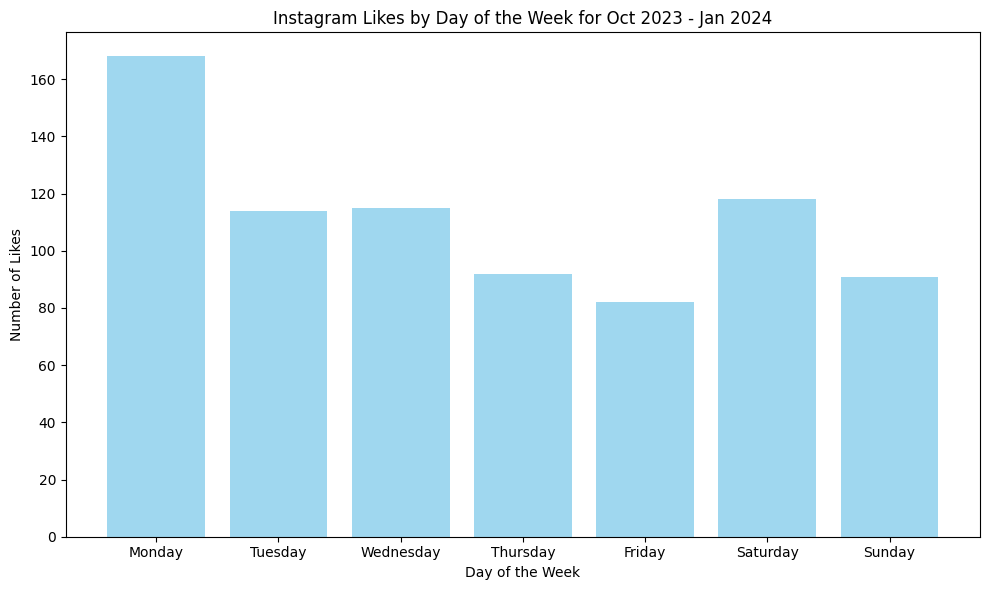

Graph saved for Feb 2024 - June 2024 at likes_by_day_Feb_2024___June_2024.png


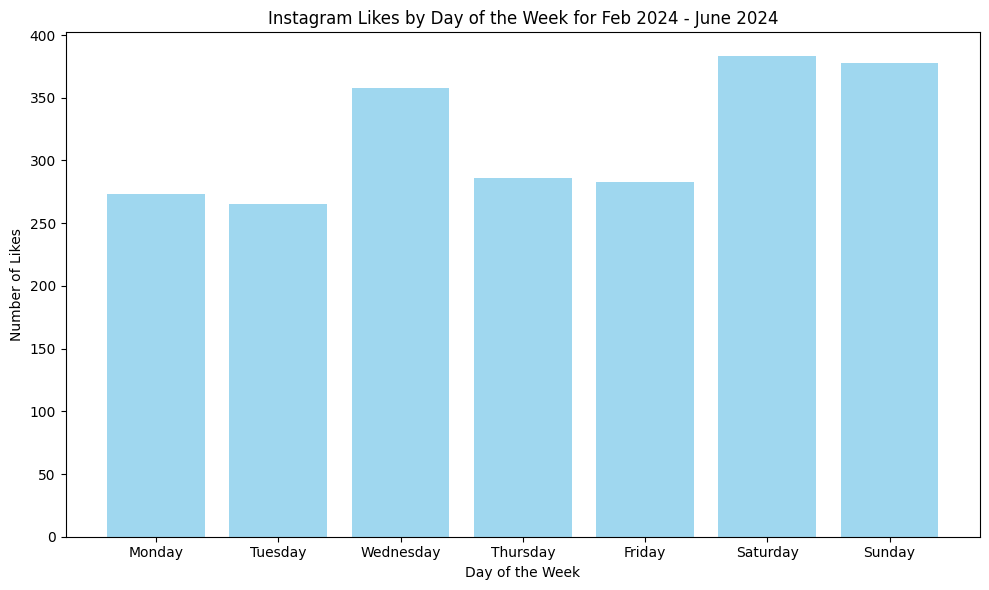

Graph saved for Oct 2024 - Now at likes_by_day_Oct_2024___Now.png


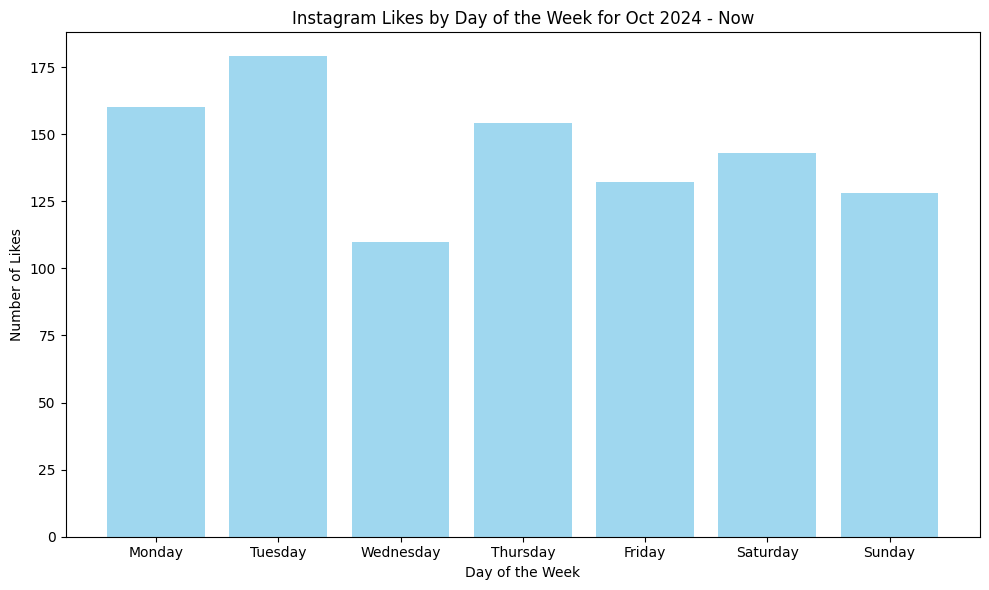

In [ ]:
file_path = '/content/extracted_likes_timestamps.csv'
data = pd.read_csv(file_path)

data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce")
data.dropna(subset=["timestamp"], inplace=True)

academic_periods = {
    "Feb 2023 - June 2023": (pd.Timestamp("2023-02-01"), pd.Timestamp("2023-06-30")),
    "Oct 2023 - Jan 2024": (pd.Timestamp("2023-10-01"), pd.Timestamp("2024-01-31")),
    "Feb 2024 - June 2024": (pd.Timestamp("2024-02-01"), pd.Timestamp("2024-06-30")),
    "Oct 2024 - Now": (pd.Timestamp("2024-10-01"), data["timestamp"].max())
}

for period_name, (start_date, end_date) in academic_periods.items():
    period_data = data[(data["timestamp"] >= start_date) & (data["timestamp"] <= end_date)].copy()
    if period_data.empty:
        print(f"No data available for {period_name}.")
        continue

    period_data["day_of_week"] = period_data["timestamp"].dt.day_name()
    weekly_likes = period_data.groupby("day_of_week").size()

    ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    weekly_likes = weekly_likes.reindex(ordered_days, fill_value=0)

    plt.figure(figsize=(10, 6))
    plt.bar(weekly_likes.index, weekly_likes.values, color="skyblue", alpha=0.8)
    plt.xlabel("Day of the Week")
    plt.ylabel("Number of Likes")
    plt.title(f"Instagram Likes by Day of the Week for {period_name}")
    plt.tight_layout()

    output_path = f"likes_by_day_{period_name.replace(' ', '_').replace('-', '_')}.png"
    plt.savefig(output_path)
    print(f"Graph saved for {period_name} at {output_path}")
    plt.show()

# DATA ANALOGY

In this part, we will look meaningful comparisons and have more insight with the graphs plotted together.

**1) Time Spent on Studying vs. Instagram**

In the below code block, we will be exploring the times when I study or check up on Instagram.

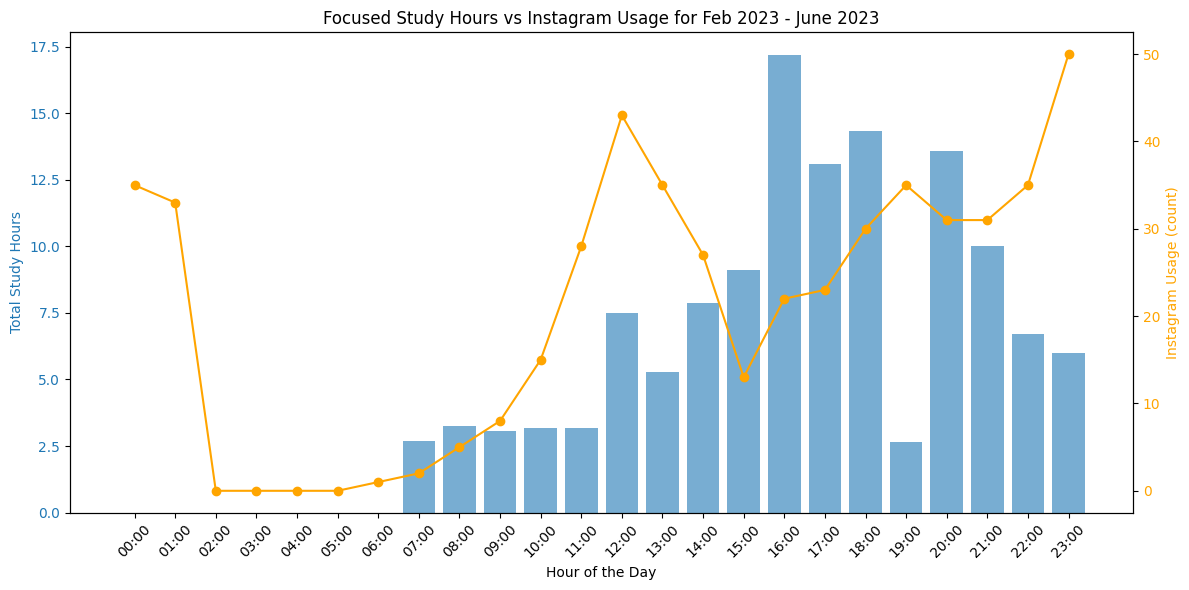

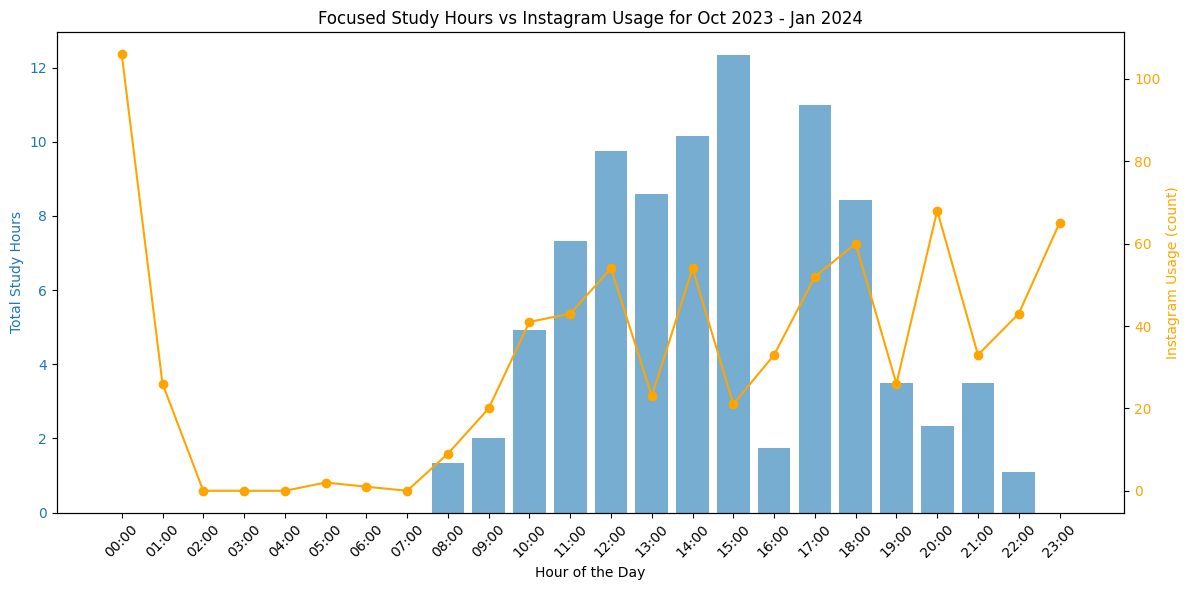

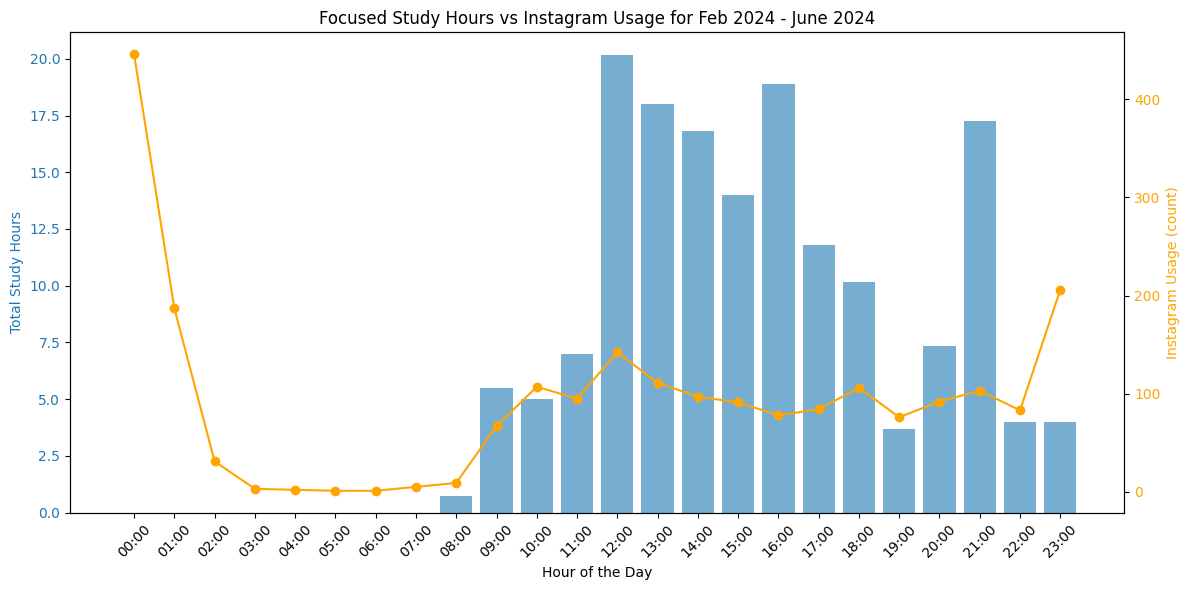

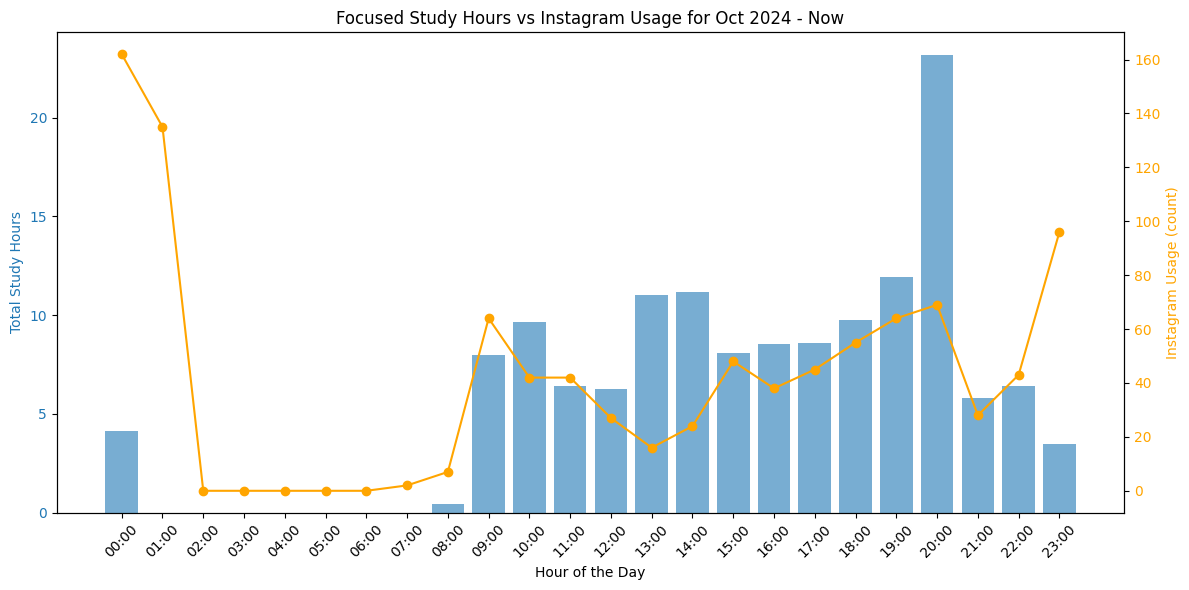

In [ ]:
study_file_path = "/content/Cleaned_and_Adjusted_Study_Data.csv"
instagram_file_path = "/content/processed_likes.csv"

output_directory = "/content/insta_usage_vs_study_graphs"
os.makedirs(output_directory, exist_ok=True)

study_data = pd.read_csv(study_file_path)
instagram_data = pd.read_csv(instagram_file_path)

study_data["Start Time"] = pd.to_datetime(study_data["Start Time"], errors="coerce").dt.tz_localize(None)
study_data["End Time"] = pd.to_datetime(study_data["End Time"], errors="coerce").dt.tz_localize(None)
study_data = study_data.dropna(subset=["Start Time", "End Time"])
study_data["Hour"] = study_data["Start Time"].dt.hour

instagram_data["timestamp"] = pd.to_datetime(instagram_data["timestamp"], errors="coerce").dt.tz_localize(None)
instagram_data = instagram_data.dropna(subset=["timestamp"])


academic_periods = {
    "Feb 2023 - June 2023": (pd.Timestamp("2023-02-01"), pd.Timestamp("2023-06-30")),
    "Oct 2023 - Jan 2024": (pd.Timestamp("2023-10-01"), pd.Timestamp("2024-01-31")),
    "Feb 2024 - June 2024": (pd.Timestamp("2024-02-01"), pd.Timestamp("2024-06-30")),
    "Oct 2024 - Now": (pd.Timestamp("2024-10-01"), instagram_data["timestamp"].max()),
}

for period_name, (start_date, end_date) in academic_periods.items():
    period_study_data = study_data[
        (study_data["Start Time"] >= start_date) & (study_data["Start Time"] <= end_date)
    ]
    period_instagram_data = instagram_data[
        (instagram_data["timestamp"] >= start_date) & (instagram_data["timestamp"] <= end_date)
    ]

    focused_hours = period_study_data.groupby("Hour")["Duration (hours)"].sum()
    instagram_hours = period_instagram_data["timestamp"].dt.hour.value_counts().sort_index()

    hours = np.arange(24)
    focused_hours = focused_hours.reindex(hours, fill_value=0)
    instagram_hours = instagram_hours.reindex(hours, fill_value=0)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color1 = 'tab:blue'
    ax1.set_xlabel("Hour of the Day")
    ax1.set_ylabel("Total Study Hours", color=color1)
    ax1.bar(hours, focused_hours, color=color1, alpha=0.6, label="Focused Study Hours")
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel("Instagram Usage (count)", color="orange")
    ax2.plot(hours, instagram_hours, color="orange", marker='o', label="Instagram Usage")
    ax2.tick_params(axis='y', labelcolor="orange")

    ax1.set_xticks(hours)
    ax1.set_xticklabels([f"{hour:02d}:00" for hour in hours], rotation=45)
    plt.title(f"Focused Study Hours vs Instagram Usage for {period_name}")

    fig.tight_layout()
    output_file = f"{output_directory}/{period_name.replace(' ', '_')}_comparison.png"
    plt.savefig(output_file)
    plt.show()


**2) Correlations**
 Why I chose to focus on the last 3 academic periods

A**ggregate Correlation of Study Time vs Instagram Usage**

*   The first graph of the academic semesters give us the aggregate correlation between the studying times vs procrastination times. We can think of it like the summary of correlations.

    -   **Hourly Correlation (Blue Bar)**

        Measures the relationship between study time and Instagram time. A near zero-value observed in each graph telling us Instagram usage and study hours are not linked at all in terms of overlapping positions observed in the above graphs.

    - **Daily Correlation (Red Bar)**

        Measures the relationship in terms of daily habits this time. A negative value observed in all of the graphs demonstrate that there is an inverse relationship, meaning that there is a tendency for study hours to be lower when Instagram is used more.


**Per-Tag Hourly Correlation with Instagram Usage**

* These graphs explore the hourly correlation, but broken down to each lecture, for specification.
*Tags with a positive correlation show that Instagram usage and study hours are tend to increase simultaneously.
*Tags with negative correlation tell us that when the Instagram usage is high, study hours for that course are lower.


**Per-Tag Daily Correlation with Instagram Usage**
* These plots show the daily correlation between Instagram Usage anf study hours for specific tags.
*Tags with negative correlation rate indicate that on the days where Instagram usage peaks, chances of me studying tend to be lower.
* Tags with positive correlation rate state that both Instagram usage and the studying hours increase together, which means I procrastinate while studying :)


<ipython-input-31-88007f755e1e>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insta_data["timestamp"] = pd.to_datetime(insta_data["timestamp"], errors="coerce").dt.tz_localize(None)


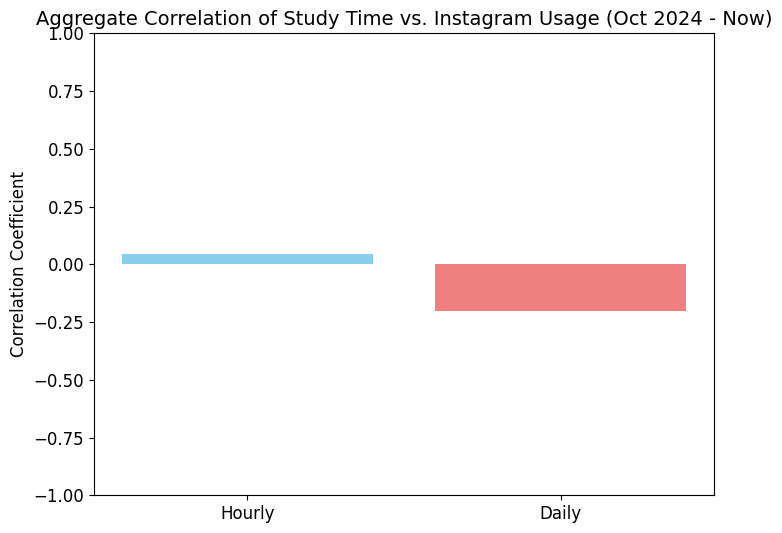

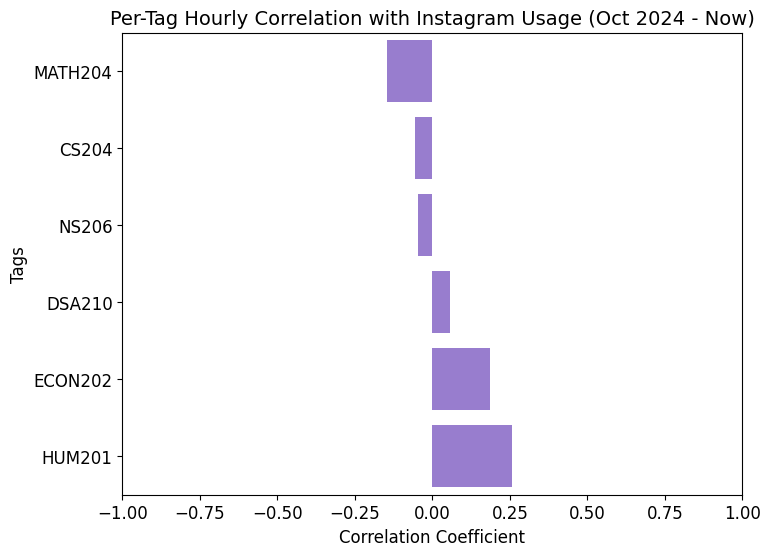

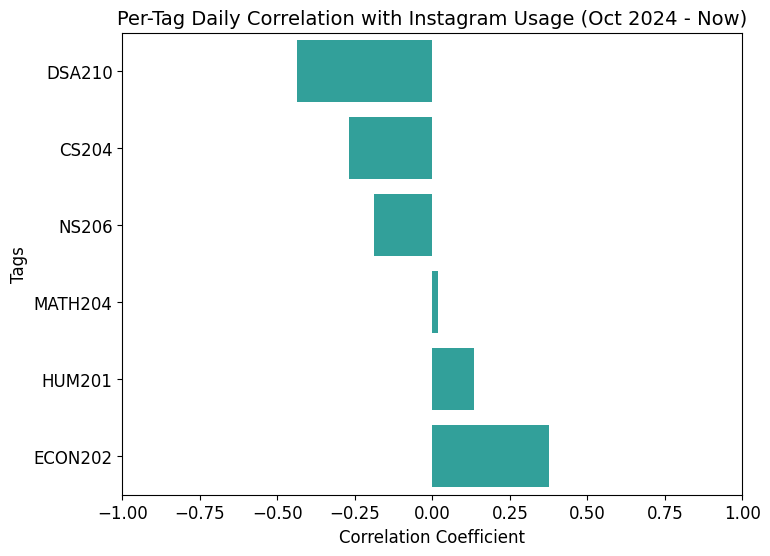

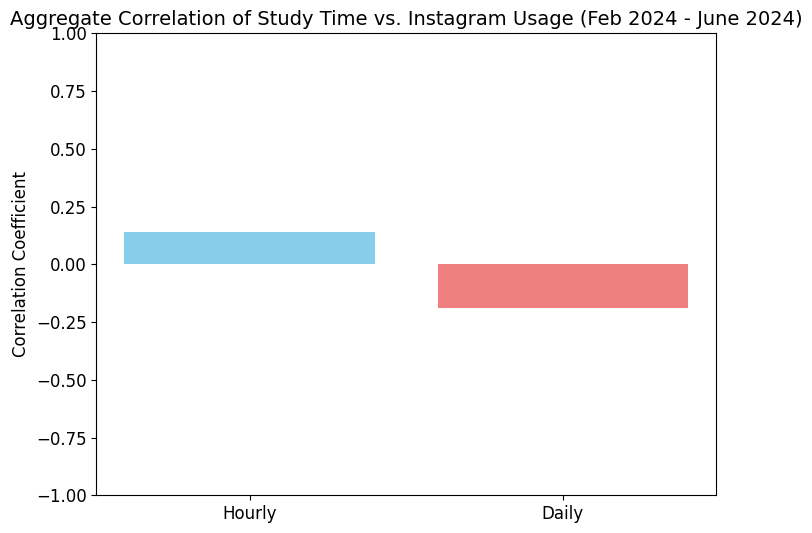

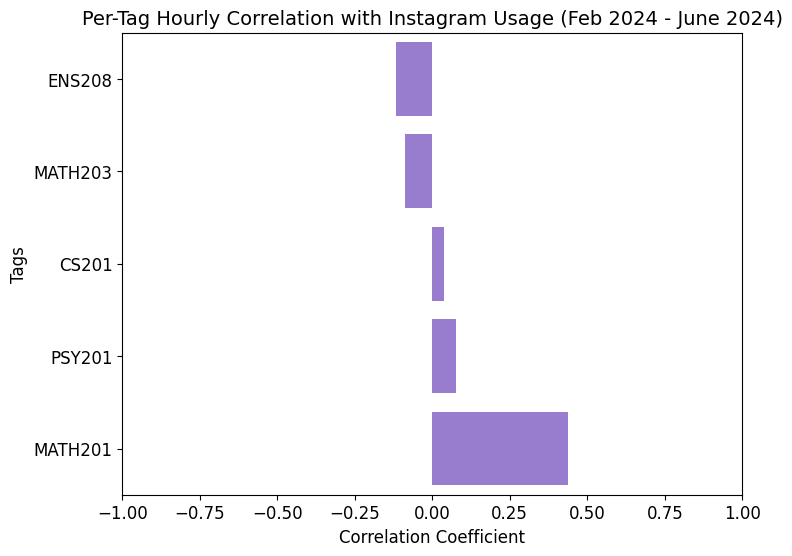

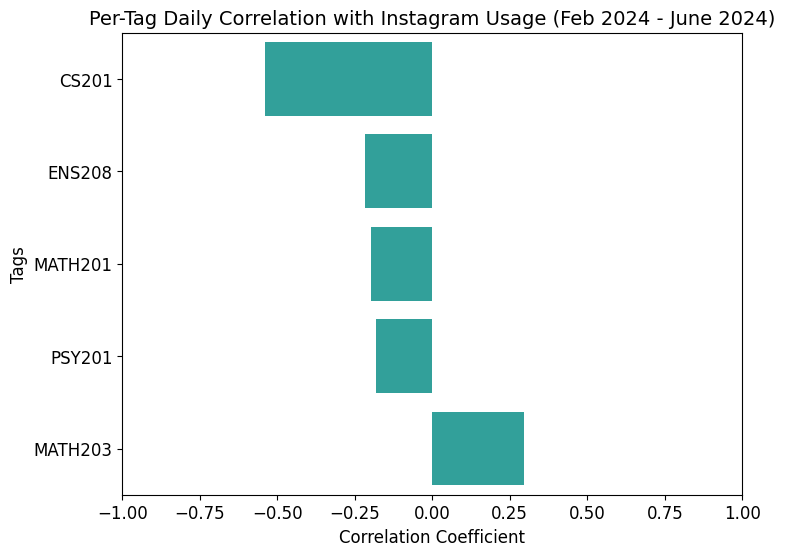

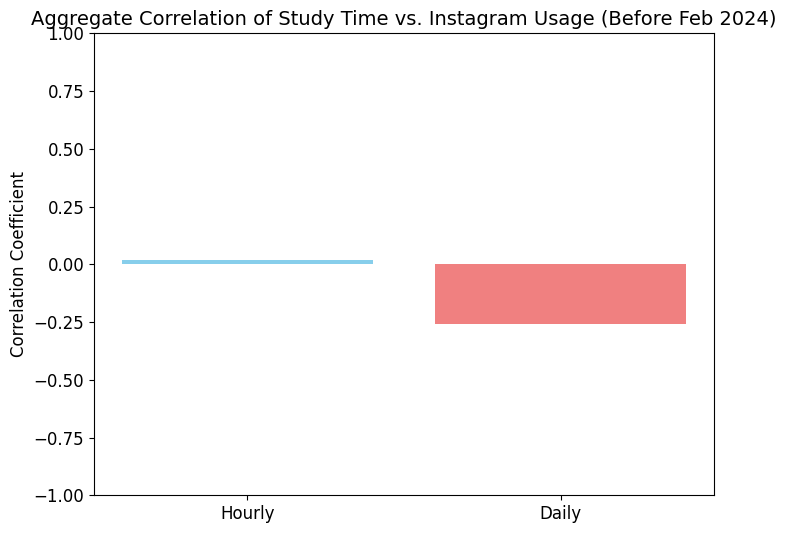

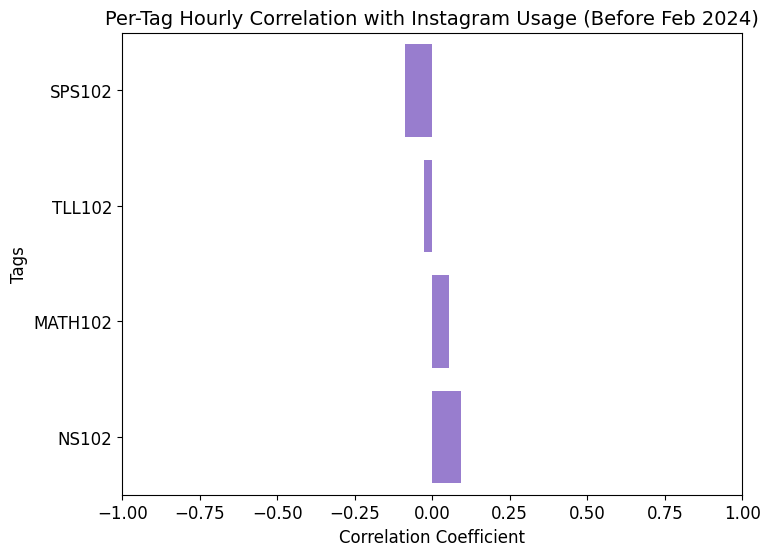

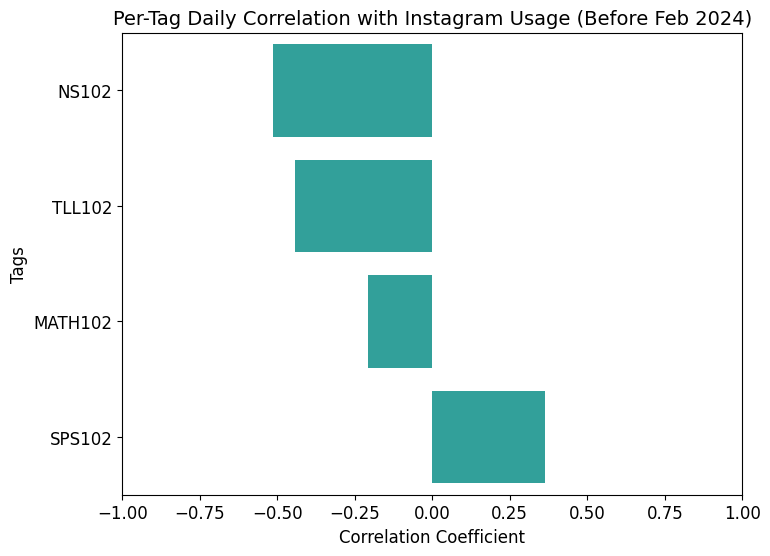

In [ ]:
study_data_path = "/content/Cleaned_and_Adjusted_Study_Data.csv"
insta_data_path = "/content/extracted_likes_timestamps.csv"
study_data = pd.read_csv(study_data_path)
insta_data = pd.read_csv(insta_data_path, header=None, names=["timestamp"])

study_data["Start Time"] = pd.to_datetime(study_data["Start Time"], errors="coerce").dt.tz_localize(None)
study_data["End Time"] = pd.to_datetime(study_data["End Time"], errors="coerce").dt.tz_localize(None)
insta_data["timestamp"] = pd.to_datetime(insta_data["timestamp"], errors="coerce").dt.tz_localize(None)


academic_periods = {
    "Oct 2024 - Now": ["CS204", "MATH204", "HUM201", "DSA210", "NS206", "ECON202"],
    "Feb 2024 - June 2024": ["MATH201", "MATH203", "ENS208", "CS201", "PSY201"],
    "Before Feb 2024": ["TLL102", "SPS102", "NS102", "MATH102"] }

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

output_dir = "./graphs"
os.makedirs(output_dir, exist_ok=True)


heatmap_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Pastel blue and coral
bar_colors = {
    "aggregate": ["skyblue", "lightcoral"],  # Two pastel colors
    "hourly_tag": "mediumpurple",
    "daily_tag": "lightseagreen"
}

def analyze_and_plot(period_name, tags, study_data, insta_data, start_date, end_date):

    period_study = study_data.loc[
        (study_data["Start Time"] >= start_date) &
        (study_data["Start Time"] <= end_date) &
        (study_data["Tag"].isin(tags))
        ].copy()

    period_insta = insta_data.loc[
        (insta_data["timestamp"] >= start_date) &
        (insta_data["timestamp"] <= end_date)
        ].copy()

    if period_study.empty or period_insta.empty:
        print(f"No data for {period_name}. Skipping.")
        return

    period_study["hour"] = period_study["Start Time"].dt.hour
    period_study["day"] = period_study["Start Time"].dt.day_name()
    period_study["day"] = pd.Categorical(period_study["day"], categories=day_order, ordered=True)

    period_insta["hour"] = period_insta["timestamp"].dt.hour
    period_insta["day"] = period_insta["timestamp"].dt.day_name()
    period_insta["day"] = pd.Categorical(period_insta["day"], categories=day_order, ordered=True)

    hourly_focus = (
        period_study
        .groupby(["Tag", "hour"], observed=False)["Duration (hours)"]
        .sum()
        .unstack(fill_value=0) )

    daily_focus = (
        period_study
        .groupby(["Tag", "day"], observed=False)["Duration (hours)"]
        .sum()
        .unstack(fill_value=0) )

    existing_days = [c for c in day_order if c in daily_focus.columns]
    daily_focus = daily_focus.reindex(columns=existing_days)

    hourly_insta = period_insta.groupby("hour").size()
    daily_insta = period_insta.groupby("day", observed=False).size().reindex(day_order, fill_value=0)

    hourly_sum = hourly_focus.sum(axis=0)
    hour_corr = hourly_sum.corr(hourly_insta)

    daily_sum = daily_focus.sum(axis=0)
    day_corr = daily_sum.corr(daily_insta)

    tag_hourly_corr = {}
    for tag in hourly_focus.index:
        tag_series = hourly_focus.loc[tag]
        corr_val = tag_series.corr(hourly_insta)
        tag_hourly_corr[tag] = corr_val
    df_tag_hourly_corr = pd.DataFrame.from_dict(tag_hourly_corr, orient="index", columns=["Hourly Correlation"])

    tag_daily_corr = {}
    for tag in daily_focus.index:
        tag_series = daily_focus.loc[tag]
        corr_val = tag_series.corr(daily_insta)
        tag_daily_corr[tag] = corr_val
    df_tag_daily_corr = pd.DataFrame.from_dict(tag_daily_corr, orient="index", columns=["Daily Correlation"])

    plt.figure(figsize=(8, 6))
    plt.bar(["Hourly", "Daily"], [hour_corr, day_corr], color=bar_colors["aggregate"])
    plt.title(f"Aggregate Correlation of Study Time vs. Instagram Usage ({period_name})", fontsize=14)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.ylim(-1, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f"{output_dir}/aggregate_correlation_{period_name}.png")
    plt.show()
    plt.close()
    plt.show()

    df_tag_hourly_corr.sort_values("Hourly Correlation", inplace=True)
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Hourly Correlation", y=df_tag_hourly_corr.index, data=df_tag_hourly_corr,
                color=bar_colors["hourly_tag"])
    plt.title(f"Per-Tag Hourly Correlation with Instagram Usage ({period_name})", fontsize=14)
    plt.xlim(-1, 1)
    plt.xlabel("Correlation Coefficient", fontsize=12)
    plt.ylabel("Tags", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f"{output_dir}/per_tag_hourly_correlation_{period_name}.png")
    plt.show()
    plt.close()

    df_tag_daily_corr.sort_values("Daily Correlation", inplace=True)
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Daily Correlation", y=df_tag_daily_corr.index, data=df_tag_daily_corr, color=bar_colors["daily_tag"])
    plt.title(f"Per-Tag Daily Correlation with Instagram Usage ({period_name})", fontsize=14)
    plt.xlim(-1, 1)
    plt.xlabel("Correlation Coefficient", fontsize=12)
    plt.ylabel("Tags", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f"{output_dir}/per_tag_daily_correlation_{period_name}.png")
    plt.show()
    plt.close()

academic_period_dates = {
    "Oct 2024 - Now": ("2024-10-01", insta_data["timestamp"].max()),
    "Feb 2024 - June 2024": ("2024-02-01", "2024-06-30"),
    "Before Feb 2024": ("2023-09-01", "2024-01-31")
}

for period_name, tags in academic_periods.items():
    start_date, end_date = map(pd.Timestamp, academic_period_dates[period_name])
    analyze_and_plot(period_name, tags, study_data, insta_data, start_date, end_date)

**3) Density Heatmaps**

We will delve into a better visualized verison of the hourly and the daily correlations in order to have a better insight for the hypothesis.


- **Hourly Correlation Heatmaps**
    These heatmaps examine how my Instagram usage and study sessions correlate across specific hours of the day for various course tags.
    It highlights time-of-day patterns where study sessions align, or just do not align with my Instagram activity.

- **Daily Correlation Heatmap**
    These examine the correlation between my Instagram usage and study sessions on specific days of the week for various course tags per academic period. It reveals patterns of day-to-day consistency or variability in how my Instagram usage aligns with my study time.

	  



Saved plot to ./updated_graphs/density_hourly_correlation_Oct 2024 - Now.png


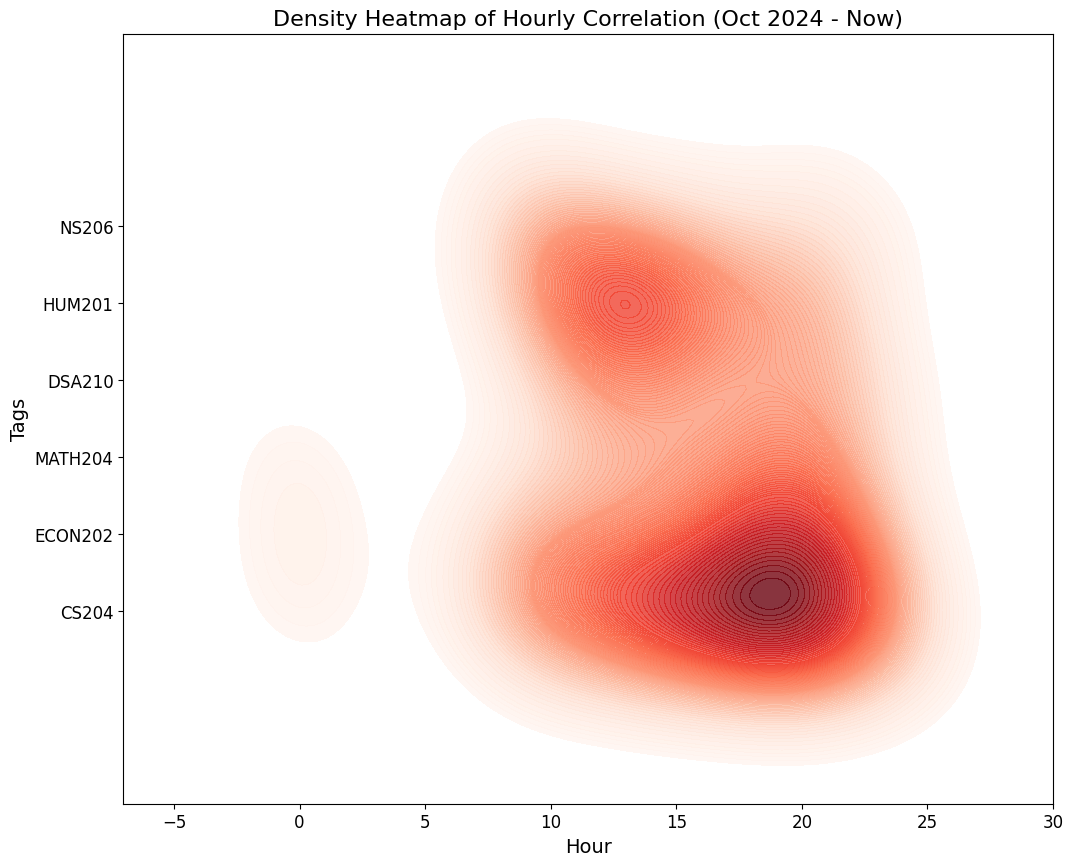

Saved plot to ./updated_graphs/density_daily_correlation_Oct 2024 - Now.png


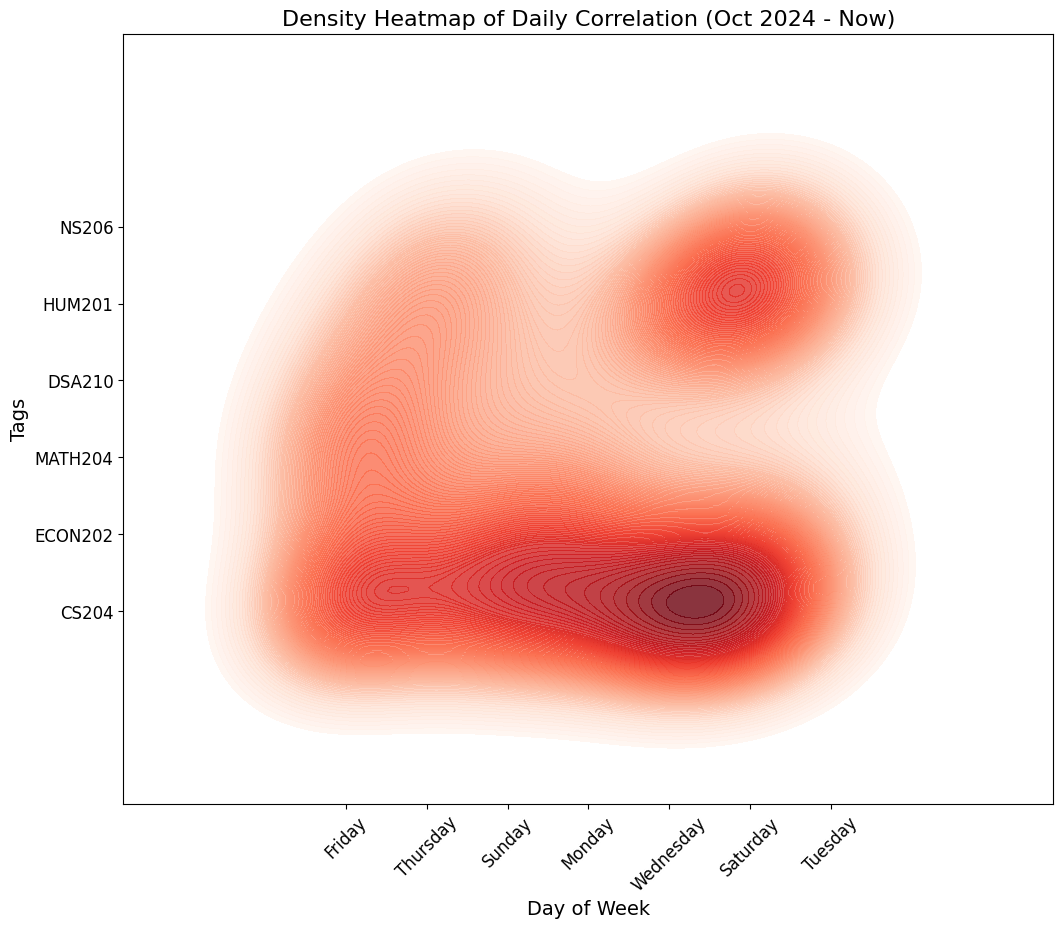

Saved plot to ./updated_graphs/density_hourly_correlation_Feb 2024 - June 2024.png


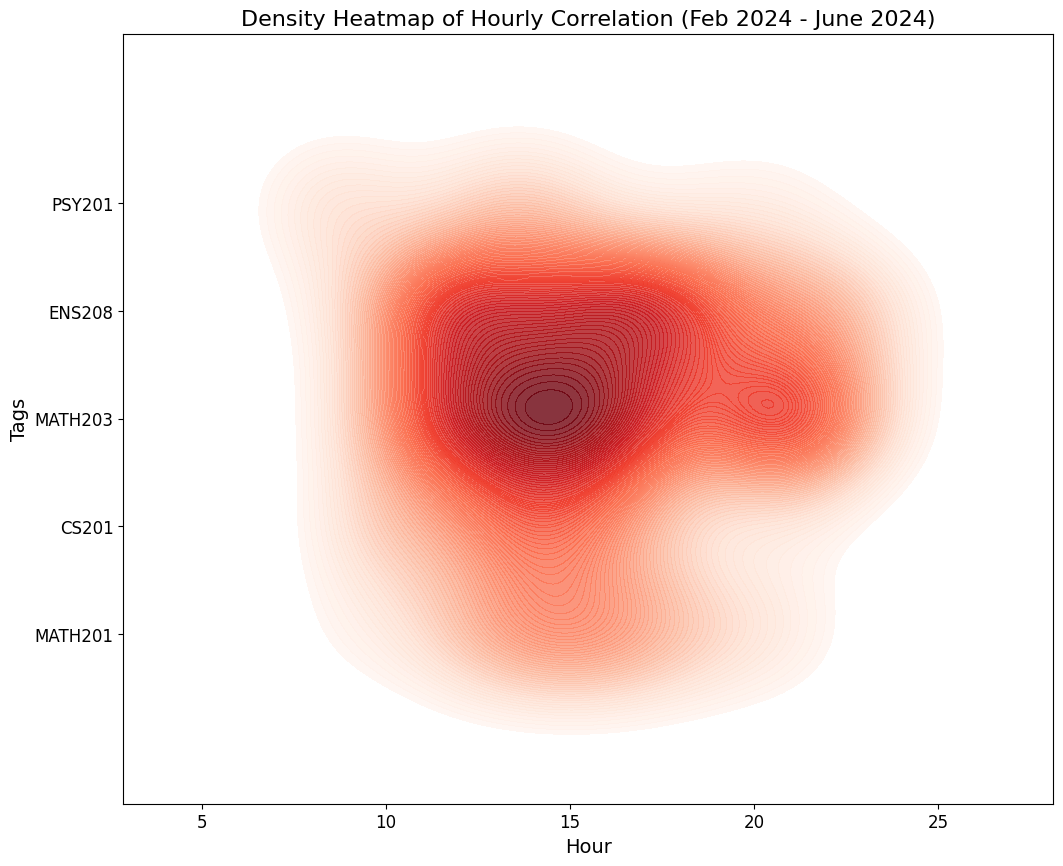

Saved plot to ./updated_graphs/density_daily_correlation_Feb 2024 - June 2024.png


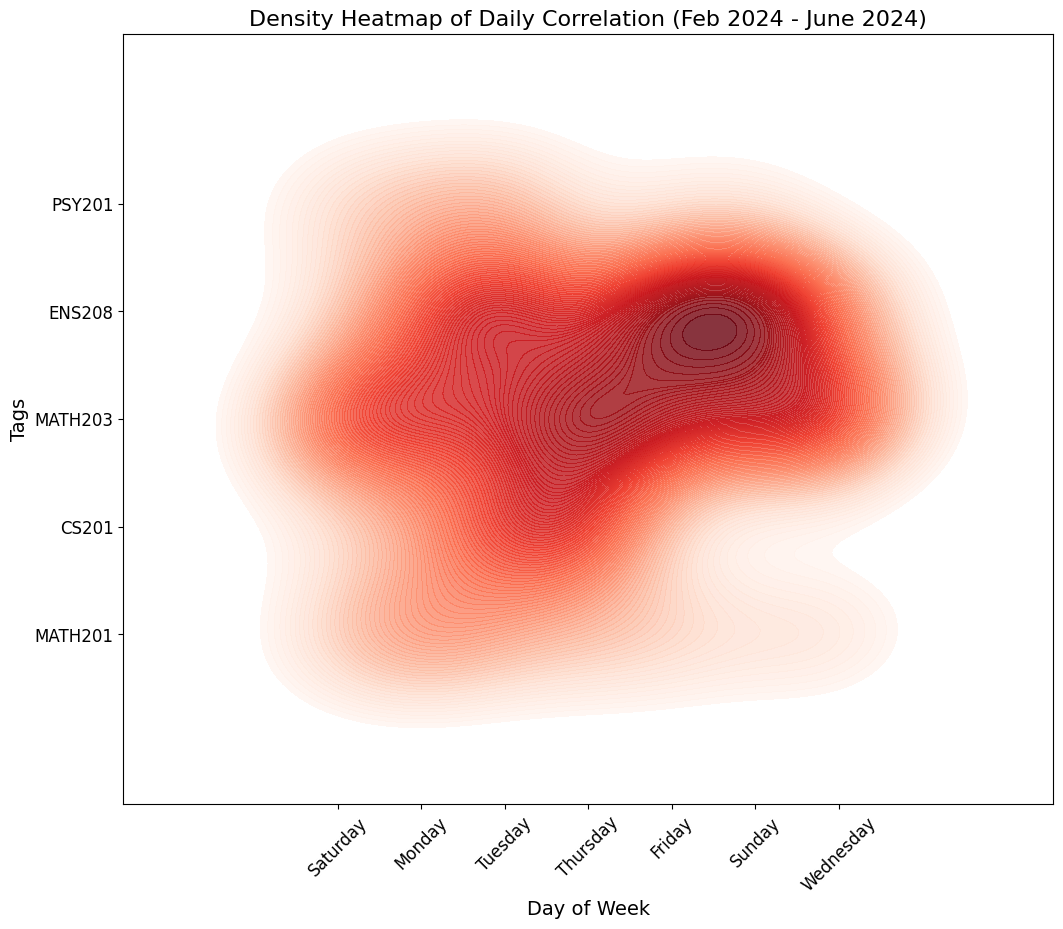

Saved plot to ./updated_graphs/density_hourly_correlation_Before Feb 2024.png


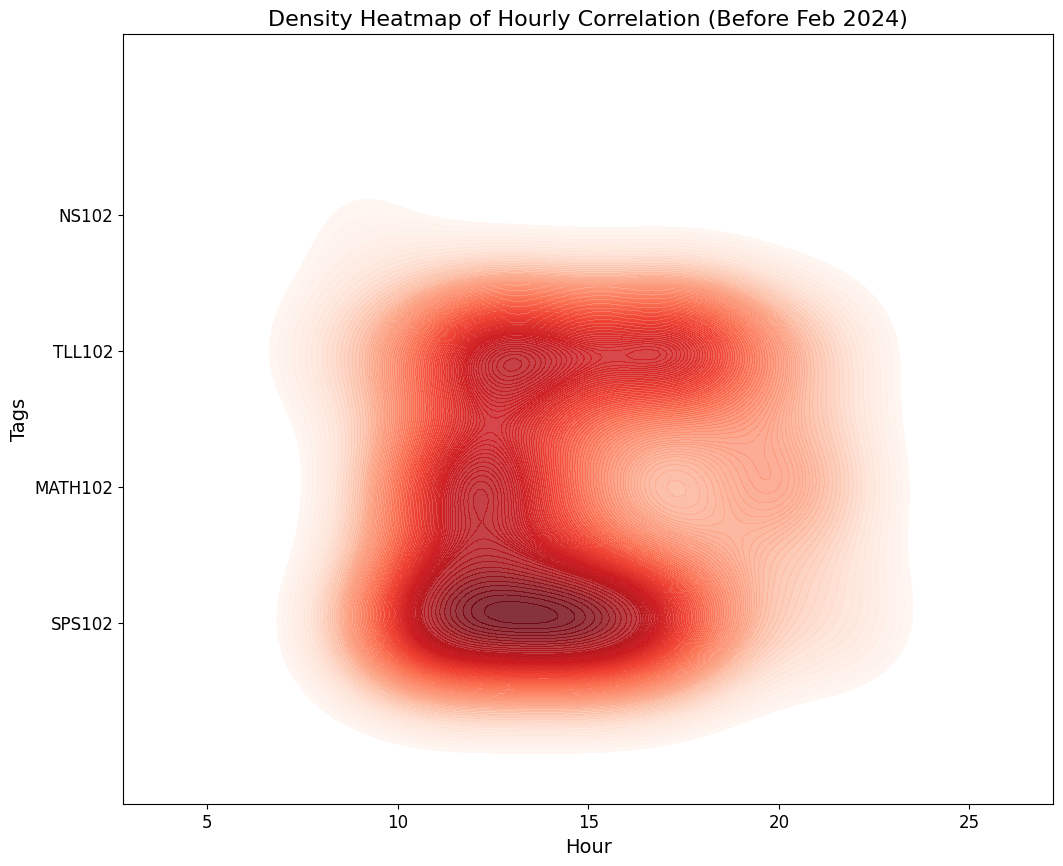

Saved plot to ./updated_graphs/density_daily_correlation_Before Feb 2024.png


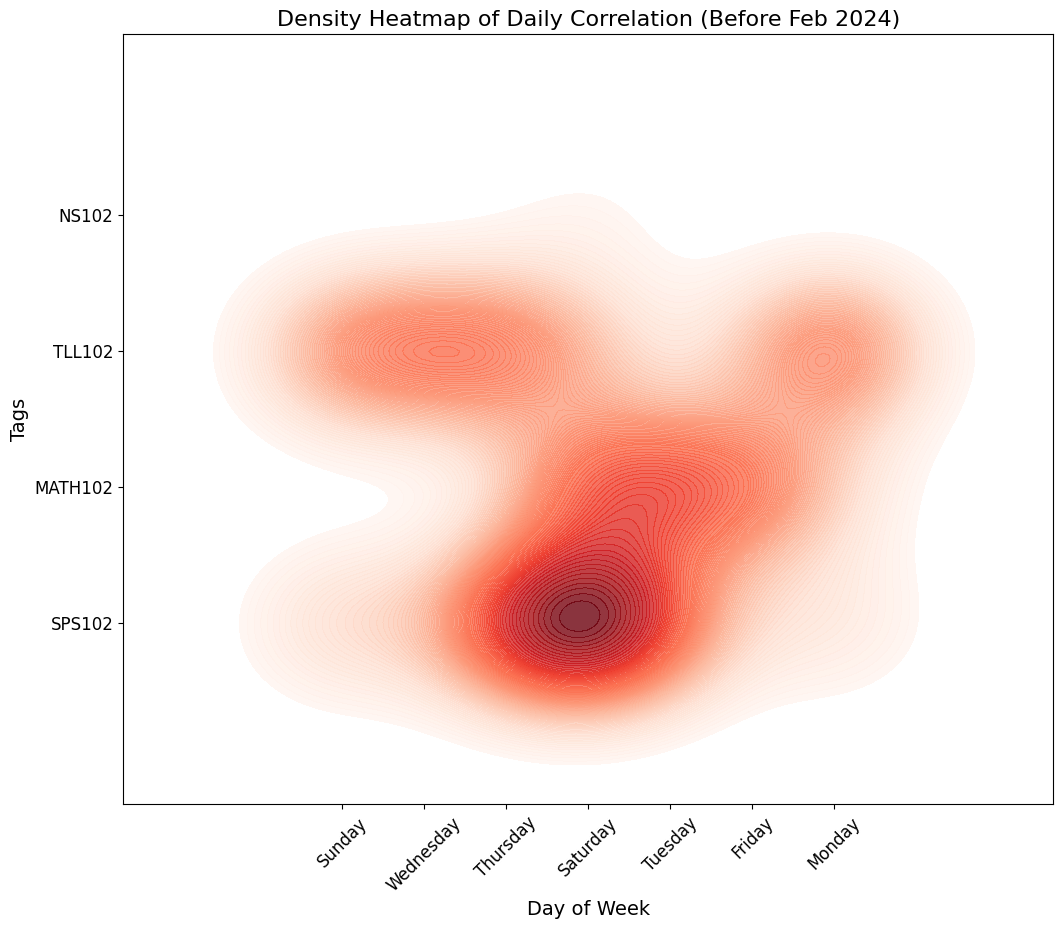

In [ ]:
study_data_path = "/content/Cleaned_and_Adjusted_Study_Data.csv"
insta_data_path = "/content/extracted_likes_timestamps.csv"
study_data = pd.read_csv(study_data_path)
insta_data = pd.read_csv(insta_data_path)

study_data["Start Time"] = pd.to_datetime(study_data["Start Time"], errors="coerce").dt.tz_localize(None)
study_data["End Time"] = pd.to_datetime(study_data["End Time"], errors="coerce").dt.tz_localize(None)
insta_data["timestamp"] = pd.to_datetime(insta_data["timestamp"], errors="coerce")

academic_periods = {
    "Oct 2024 - Now": ["CS204", "MATH204", "HUM201", "DSA210", "NS206", "ECON202"],
    "Feb 2024 - June 2024": ["MATH201", "MATH203", "ENS208", "CS201", "PSY201"],
    "Before Feb 2024": ["TLL102", "SPS102", "NS102", "MATH102"] }

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

output_dir = "./updated_graphs"
os.makedirs(output_dir, exist_ok=True)

def create_density_heatmap(data_x, data_y, xlabel, ylabel, title, output_path):

    if data_x.dtype == 'object' or isinstance(data_x.dtype, pd.CategoricalDtype):
        x_labels = data_x.unique()
        x_numeric = data_x.astype('category').cat.codes
    else:
        x_numeric = data_x
        x_labels = None

    if data_y.dtype == 'object' or isinstance(data_y.dtype, pd.CategoricalDtype):
        y_labels = data_y.unique()
        y_numeric = data_y.astype('category').cat.codes
    else:
        y_numeric = data_y
        y_labels = None

    plt.figure(figsize=(12, 10))
    sns.kdeplot(x=x_numeric, y=y_numeric, cmap="Reds", fill=True, alpha=0.8, levels=100)

    if x_labels is not None:
        plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45)

    if y_labels is not None:
        plt.yticks(ticks=range(len(y_labels)), labels=y_labels)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.savefig(output_path)
    print(f"Saved plot to {output_path}")
    plt.show()
    plt.close()


def analyze_and_plot(period_name, tags, study_data, insta_data, start_date, end_date):
    period_study = study_data.loc[
        (study_data["Start Time"] >= start_date) &
        (study_data["Start Time"] <= end_date) &
        (study_data["Tag"].isin(tags))
    ].copy()

    if period_study.empty:
        print(f"No study data for {period_name}. Skipping.")
        return

    period_study["hour"] = period_study["Start Time"].dt.hour
    period_study["day_of_week"] = period_study["Start Time"].dt.day_name()
    period_study["day_of_week"] = pd.Categorical(period_study["day_of_week"], categories=day_order, ordered=True)

    output_hourly_path = f"{output_dir}/density_hourly_correlation_{period_name}.png"
    create_density_heatmap(
        data_x=period_study["hour"],
        data_y=period_study["Tag"],
        xlabel="Hour",
        ylabel="Tags",
        title=f"Density Heatmap of Hourly Correlation ({period_name})",
        output_path=output_hourly_path
    )

    output_daily_path = f"{output_dir}/density_daily_correlation_{period_name}.png"
    create_density_heatmap(
        data_x=period_study["day_of_week"],
        data_y=period_study["Tag"],
        xlabel="Day of Week",
        ylabel="Tags",
        title=f"Density Heatmap of Daily Correlation ({period_name})",
        output_path=output_daily_path
    )

academic_period_dates = {
    "Oct 2024 - Now": ("2024-10-01", insta_data["timestamp"].max()),
    "Feb 2024 - June 2024": ("2024-02-01", "2024-06-30"),
    "Before Feb 2024": ("2023-09-01", "2024-01-31") }

for period_name, tags in academic_periods.items():
    start_date, end_date = map(pd.Timestamp, academic_period_dates[period_name])
    analyze_and_plot(period_name, tags, study_data, insta_data, start_date, end_date)

# HYPOTHESIS TESTING

All is said and done but until this point, it is not so obvious whether we reject my null hypothesis or fail to reject it, because of my altering behavior for particular courses.
In order to have a better conclusion, I have decided to apply a hypothesis testing.

To gain better insights, I calculated Spearman Correlation,   Correlation P-value, Chi-Square, and Chi-Square P-value adjacently.




In [7]:
study_data_path = "/content/Cleaned_and_Adjusted_Study_Data.csv"
insta_data_path = "/content/extracted_likes_timestamps.csv"

study_data = pd.read_csv(study_data_path)
insta_data = pd.read_csv(insta_data_path, header=None, names=["timestamp"])

study_data["Start Time"] = pd.to_datetime(study_data["Start Time"], errors="coerce").dt.tz_localize(None)
study_data["End Time"] = pd.to_datetime(study_data["End Time"], errors="coerce").dt.tz_localize(None)
insta_data["timestamp"] = pd.to_datetime(insta_data["timestamp"], errors="coerce").dt.tz_localize(None)

academic_periods = {
    "Oct 2024 - Now": ["CS204", "MATH204", "HUM201", "DSA210", "NS206", "ECON202"],
    "Feb 2024 - June 2024": ["MATH201", "MATH203", "ENS208", "CS201", "PSY201"],
    "Before Feb 2024": ["TLL102", "SPS102", "NS102", "MATH102"],
}
academic_period_dates = {
    "Oct 2024 - Now": ("2024-10-01", insta_data["timestamp"].max()),
    "Feb 2024 - June 2024": ("2024-02-01", "2024-06-30"),
    "Before Feb 2024": ("2022-09-01", "2024-01-31"), }

results = []

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

for period_name, tags in academic_periods.items():
    start_date, end_date = map(pd.Timestamp, academic_period_dates[period_name])

    period_study = study_data.loc[
        (study_data["Start Time"] >= start_date) &
        (study_data["Start Time"] <= end_date) &
        (study_data["Tag"].isin(tags))  ]

    period_insta = insta_data.loc[
        (insta_data["timestamp"] >= start_date) &
        (insta_data["timestamp"] <= end_date)  ]

    daily_study = period_study.groupby(period_study["Start Time"].dt.date)["Duration (hours)"].sum()
    daily_insta = period_insta.groupby(period_insta["timestamp"].dt.date).size()


    combined_data = pd.DataFrame({
        "Study Hours": daily_study,
        "Instagram Usage": daily_insta
    }).fillna(0)

    if len(combined_data) > 1:
        correlation, corr_p_value = spearmanr(combined_data["Study Hours"], combined_data["Instagram Usage"])
    else:
        correlation, corr_p_value = None, None


    if not daily_study.empty and not daily_insta.empty:

        study_median = daily_study.median()
        insta_median = daily_insta.median()

        daily_study_category = daily_study.apply(lambda x: "High" if x >= study_median else "Low")
        daily_insta_category = daily_insta.apply(lambda x: "High" if x >= insta_median else "Low")

        contingency_table = pd.crosstab(daily_study_category, daily_insta_category)

        if contingency_table.shape == (2, 2):
            chi2, chi_p_value, _, _ = chi2_contingency(contingency_table)
        else:
            chi2, chi_p_value = None, None
    else:
        chi2, chi_p_value = None, None

    results.append({
        "Period": period_name,
        "Spearman Correlation": correlation,
        "Correlation P-value": corr_p_value,
        "Chi-Square": chi2,
        "Chi-Square P-value": chi_p_value
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Period  Spearman Correlation  Correlation P-value  Chi-Square  Chi-Square P-value
0        Oct 2024 - Now              0.180603             0.209441    0.017760            0.893981
1  Feb 2024 - June 2024             -0.095770             0.243693    0.077381            0.780879
2       Before Feb 2024             -0.088934             0.059993    0.176952            0.674006


<ipython-input-7-2653a4f506b5>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insta_data["timestamp"] = pd.to_datetime(insta_data["timestamp"], errors="coerce").dt.tz_localize(None)


* Here, this code creates a table which summarizes the analysis.

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

study_data_path = "/content/Cleaned_and_Adjusted_Study_Data.csv"
insta_data_path = "/content/extracted_likes_timestamps.csv"

study_data = pd.read_csv(study_data_path)
insta_data = pd.read_csv(insta_data_path, header=None, names=["timestamp"])

study_data["Start Time"] = pd.to_datetime(
    study_data["Start Time"], errors="coerce"
).dt.tz_localize(None)
study_data["End Time"] = pd.to_datetime(
    study_data["End Time"], errors="coerce"
).dt.tz_localize(None)
insta_data["timestamp"] = pd.to_datetime(
    insta_data["timestamp"], errors="coerce"
).dt.tz_localize(None)

academic_periods = {
    "Oct 2024 - Now": ["CS204", "MATH204", "HUM201", "DSA210", "NS206", "ECON202"],
    "Feb 2024 - June 2024": ["MATH201", "MATH203", "ENS208", "CS201", "PSY201"],
    "Before Feb 2024": ["TLL102", "SPS102", "NS102", "MATH102"],
}
academic_period_dates = {
    "Oct 2024 - Now": ("2024-10-01", insta_data["timestamp"].max()),
    "Feb 2024 - June 2024": ("2024-02-01", "2024-06-30"),
    "Before Feb 2024": ("2022-09-01", "2024-01-31"),
}

results = []

for period_name, tags in academic_periods.items():
    start_date, end_date = map(pd.Timestamp, academic_period_dates[period_name])

    period_study = study_data.loc[
        (study_data["Start Time"] >= start_date) &
        (study_data["Start Time"] <= end_date) &
        (study_data["Tag"].isin(tags))
    ]

    period_insta = insta_data.loc[
        (insta_data["timestamp"] >= start_date) &
        (insta_data["timestamp"] <= end_date)
    ]

    hourly_study = (
        period_study.groupby(period_study["Start Time"].dt.hour)["Duration (hours)"].sum()
    )
    hourly_insta = period_insta.groupby(period_insta["timestamp"].dt.hour).size()

    daily_study = (
        period_study.groupby(period_study["Start Time"].dt.date)["Duration (hours)"].sum()
    )
    daily_insta = period_insta.groupby(period_insta["timestamp"].dt.date).size()

    combined_hourly = pd.DataFrame({
        "Study Hours": hourly_study,
        "Instagram Usage": hourly_insta
    }).fillna(0)

    combined_daily = pd.DataFrame({
        "Study Hours": daily_study,
        "Instagram Usage": daily_insta
    }).fillna(0)

    if (
        len(combined_hourly) > 1
        and combined_hourly["Study Hours"].nunique() > 1
        and combined_hourly["Instagram Usage"].nunique() > 1
    ):
        hourly_corr, hourly_p = spearmanr(
            combined_hourly["Study Hours"], combined_hourly["Instagram Usage"]
        )
        hourly_interpretation = (
            f"Hypothesis {'is rejected' if hourly_p < 0.05 else 'fails to be rejected'} "
            f"at p-value {hourly_p:.3f}"
        )
    else:
        hourly_corr, hourly_p, hourly_interpretation = None, None, "Insufficient variability for correlation"

    if (
        len(combined_daily) > 1
        and combined_daily["Study Hours"].nunique() > 1
        and combined_daily["Instagram Usage"].nunique() > 1
    ):
        daily_corr, daily_p = spearmanr(
            combined_daily["Study Hours"], combined_daily["Instagram Usage"]
        )
        daily_interpretation = (
            f"Hypothesis {'is rejected' if daily_p < 0.05 else 'fails to be rejected'} "
            f"at p-value {daily_p:.3f}"
        )
    else:
        daily_corr, daily_p, daily_interpretation = None, None, "Insufficient variability for correlation"

    results.append({
        "Period": period_name,
        "Hourly Correlation": hourly_corr,
        "Hourly P-value": hourly_p,
        "Hourly Interpretation": hourly_interpretation,
        "Daily Correlation": daily_corr,
        "Daily P-value": daily_p,
        "Daily Interpretation": daily_interpretation
    })

results_df = pd.DataFrame(results)
table_str = tabulate(results_df, headers="keys", tablefmt="grid")
print("\n--- Hypothesis Testing Results ---\n")
print(table_str)


--- Hypothesis Testing Results ---

+----+----------------------+----------------------+------------------+--------------------------------------------------+---------------------+-----------------+--------------------------------------------------+
|    | Period               |   Hourly Correlation |   Hourly P-value | Hourly Interpretation                            |   Daily Correlation |   Daily P-value | Daily Interpretation                             |
+====+======================+======================+==================+==================================================+=====================+=================+==================================================+
|  0 | Oct 2024 - Now       |             0.286926 |      0.207285    | Hypothesis fails to be rejected at p-value 0.207 |           0.180603  |       0.209441  | Hypothesis fails to be rejected at p-value 0.209 |
+----+----------------------+----------------------+------------------+------------------------------------

# FURHTER INSIGHTS: LINEAR REGRESSION

Here, to again find out whether Instagram Usage affects my focused study hours, but this time with a linear regression model.

It failed to support the hypotheses, since as you can see below, **R² score was negative (-0.062)**, meaning Instagram usage couldn’t explain the variance in study hours. This suggests that no significant linear relationship between the two variables.

(Since linear regresson model failed, I tried polynomial regression and it gave worse results, so I decided not to include it here.)


In [ ]:
study_data_path = "/content/Cleaned_and_Adjusted_Study_Data.csv"
likes_data_path = "/content/processed_likes.csv"

study_data = pd.read_csv(study_data_path)
likes_data = pd.read_csv(likes_data_path)

study_data['Start Time'] = pd.to_datetime(study_data['Start Time'], format='mixed', errors='coerce')
study_data['End Time'] = pd.to_datetime(study_data['End Time'], format='mixed', errors='coerce')
likes_data['timestamp'] = pd.to_datetime(likes_data['timestamp'], format='mixed', errors='coerce')

study_data = study_data.dropna(subset=['Start Time', 'End Time'])
likes_data = likes_data.dropna(subset=['timestamp'])

likes_data['date'] = likes_data['timestamp'].dt.date
instagram_usage_daily = likes_data.groupby('date').size().reset_index(name='Instagram Usage')

study_data['date'] = study_data['Start Time'].dt.date
daily_study_hours = study_data.groupby('date')['Adjusted Hours'].sum().reset_index(name='Study Hours')

merged_data = pd.merge(instagram_usage_daily, daily_study_hours, on='date', how='inner')


features = merged_data[['Instagram Usage']].values
target = merged_data['Study Hours'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

Mean Squared Error: 4.3358202180848755
R2 Score: -0.06214898007604619


# FURTHER INSIGTS: DECISION TREE MODEL TO PREDICT MY TENDENCIES

Below, there is an attempt of using decision tree model is used in order to see if the model can successfully predict the outcomes only from my provided data.

I first split the data in two (%80-%20) by default.

And then data is shuffled, so the order of the records do not cause any bias.

The trained model predicts on the test set. And then the confusion matrix visualizes correct vs. incorrect predictions at the end.

**Accuracy**: 0.728 indicates that the model correctly classified Instagram usage about **73%** of the time.

**Precision**: **14%** shows how low it was for model to correctly identify true Instagram usages.

**AUC-ROC**: **48.4%** implies the model barely performs better than random guessing in distinguishing between classes.





Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2}
Accuracy: 0.728
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        80
           1       0.14      0.04      0.07        23

    accuracy                           0.73       103
   macro avg       0.46      0.48      0.45       103
weighted avg       0.63      0.73      0.67       103

Precision: 0.143
AUC-ROC: 0.484


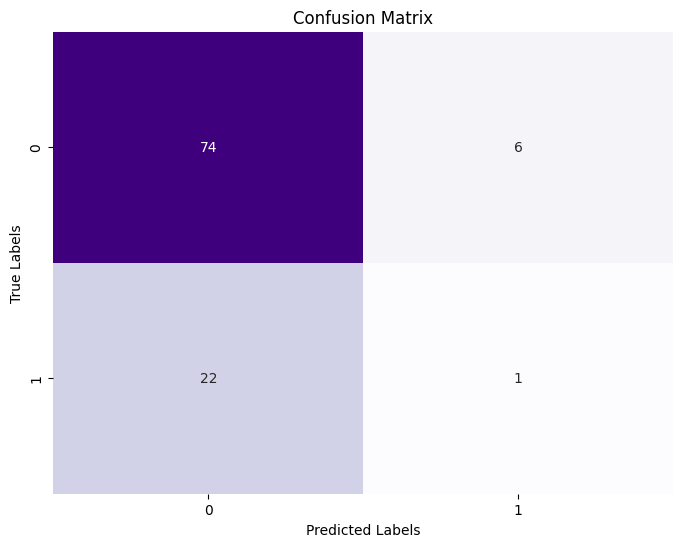

Distribution of target (Instagram Used) in the test set:
Instagram Used
0    80
1    23
Name: count, dtype: int64


In [ ]:
study_data_path = '/content/Cleaned_and_Adjusted_Study_Data.csv'
insta_data_path = '/content/extracted_likes_timestamps.csv'
study_data = pd.read_csv(study_data_path)
insta_data = pd.read_csv(insta_data_path)

study_data["Start Time"] = pd.to_datetime(study_data["Start Time"], errors="coerce").dt.tz_localize(None)
study_data["End Time"] = pd.to_datetime(study_data["End Time"], errors="coerce").dt.tz_localize(None)
insta_data["timestamp"] = pd.to_datetime(insta_data["timestamp"], errors="coerce").dt.tz_localize(None)

study_data["Instagram Used"] = study_data.apply(
    lambda row: int(
        insta_data["timestamp"].between(row["Start Time"], row["End Time"]).any()
    ),
    axis=1 )

shuffled_df = study_data.sample(frac=1, random_state=42).reset_index(drop=True)
y = shuffled_df["Instagram Used"]
X = shuffled_df[["Duration (hours)", "Weight", "Adjusted Hours", "Adjusted Sessions"]]

train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42 )

param_grid = {  'max_depth': [None, 10, 20], 'min_samples_leaf': [1, 2, 4] }
grid_search = GridSearchCV (
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy" )
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_x)

accuracy = accuracy_score(test_y, y_pred)
classification_report_result = classification_report(test_y, y_pred)
precision = precision_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print('Classification Report:')
print(classification_report_result)
print(f'Precision: {precision:.3f}')
print(f'AUC-ROC: {roc_auc:.3f}')

conf_matrix = confusion_matrix(test_y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Distribution of target (Instagram Used) in the test set:")
print(test_y.value_counts())